# Homework 1 Problem 1 Code

In [1]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
%matplotlib inline

def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()


class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, \
                 actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 3 options:
        'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim)\
        / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim)\
        / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z, type):
        '''
        actFun computes the activation functions
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: activations
        '''

        if(type == "tanh"):
            return np.tanh(z)
        elif(type == "sigmoid"):
            return 1 / (1 + np.exp(-z))
        elif(type == "relu"):
            return abs(z) * (z > 0)
        else:
            raise NotImplementedError

    def diff_actFun(self, z, type):
        '''
        diff_actFun computes the derivatives of the activation 
        functions wrt the net input
        :param z: net input
        :param type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt 
        the net input
        '''

        # YOU IMPLEMENT YOUR diff_actFun HERE
        if(type == "tanh"):
            return 1.0 - np.tanh(z)**2
        elif(type == "sigmoid"):
            return self.actFun(z, type)*(1-self.actFun(z, type))
        elif(type == "relu"):
            return (z > 0) * 1
        else:
            raise NotImplementedError
        

    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes 
        the two probabilities,
        one for class 0 and one for class 1
        :param X: input data
        :param actFun: activation function
        :return:
        '''

        # YOU IMPLEMENT YOUR feedforward HERE

        self.z1 = X @ self.W1 + self.b1
        self.a1 = actFun(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return None

    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        # Calculating the loss

        # YOU IMPLEMENT YOUR CALCULATION OF THE LOSS HERE
        data_loss = -np.sum(np.log(self.probs[range(num_examples),y]))

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1))\
                                            + np.sum(np.square(self.W2)))
        return (1. / num_examples) * data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop implements backpropagation to compute the gradients used to 
        update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''

        # IMPLEMENT YOUR BACKPROP HERE
        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1


        dW2 = self.a1.T @ delta3
        db2 = np.sum(delta3, axis=0)
        dW1 = X.T@((delta3 @ self.W2.T) * \
                self.diff_actFun(self.z1, type=self.actFun_type))
        db1 = np.sum((delta3 @ self.W2.T) * \
                self.diff_actFun(self.z1, type=self.actFun_type), axis=0)



        return dW1, dW2, db1, db2

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm 
        runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X, y)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -epsilon * dW1
            self.b1 += -epsilon * db1
            self.W2 += -epsilon * dW2
            self.b2 += -epsilon * db2



            # print(self.W1)
            # while(i==2):
            #     True
            
            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, 
            #so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plots the decision boundary
        created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary(lambda x: self.predict(x), X, y)

class Layer(object):
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(input_size, output_size) / np.sqrt(input_size)
        self.b = np.zeros((1, output_size))

        self.dW = None
        self.db = None

    def forward(self, x, actFun):

        # Remember the old activations
        self.x = x
        self.z = x @ self.W + self.b
        self.a = actFun(self.z)
        return self.a

    def backward(self, da, diff_actFun):
        dz = da * diff_actFun(self.z)
        dW = self.x.T @ dz
        db = np.sum(dz, axis=0)
        da_prev = (dz @ self.W.T)
        return (da_prev, dW, db)


class DeepNeuralNetwork(NeuralNetwork):
    def __init__(self, 
                 nn_input_dim, 
                 nn_hidden_dim, 
                 nn_output_dim,
                 n_layers=2 ,
                 actFun_type='tanh', 
                 reg_lambda=0.01, 
                 seed=0):
        super(DeepNeuralNetwork, self).__init__(nn_input_dim,
                                                nn_hidden_dim, 
                                                nn_output_dim, 
                                                actFun_type=actFun_type, 
                                                reg_lambda=reg_lambda, 
                                                seed=seed)

        np.random.seed(seed)

        self.n_layers = n_layers

        self.layers = []
        self.layers.append(Layer(self.nn_input_dim, self.nn_hidden_dim))
        for i in range(1, n_layers-1):
            self.layers.append(Layer(self.nn_hidden_dim, self.nn_hidden_dim))
        self.layers.append(Layer(self.nn_hidden_dim, self.nn_output_dim))


    def feedforward(self, X, actFun):
        a = X
        for l in range(self.n_layers):
            a = self.layers[l].forward(a, actFun)

        exp_scores = np.exp(self.layers[-1].z)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return None

    def backprop(self, X, y):
        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1

        # Appending the final a
        (da_prev, self.layers[-1].dW, self.layers[-1].db) =\
        self.layers[-1].backward(delta3, lambda x: 1)
        for l in reversed(range(0, self.n_layers-1)):
            (da_prev, self.layers[l].dW, self.layers[l].db) =\
            self.layers[l].backward(da_prev, lambda x: \
                                    self.diff_actFun(x, self.actFun_type))


    def calculate_loss(self, X, y):
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        # Calculating the loss

        # YOU IMPLEMENT YOUR CALCULATION OF THE LOSS HERE
        data_loss = -np.sum(np.log(self.probs[range(num_examples),y]))

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * \
        sum([np.sum(np.square(self.layers[i].W)) for i in range(self.n_layers)])
        return (1. / num_examples) * data_loss

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
            # Backpropagation
            self.backprop(X, y)


            # Add regularization terms (b1 and b2 don't have regularization terms)
            for j in range(self.n_layers):
                self.layers[j].dW += self.reg_lambda * self.layers[j].W
                self.layers[j].W += -epsilon * self.layers[j].dW
                self.layers[j].b += -epsilon * self.layers[j].db

            # print(self.layers[-2].W)
            # while(i==2):
            #     True
            
            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, 
            # so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))



## Visualizing make moons

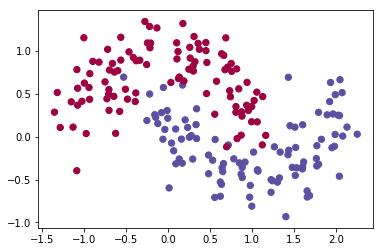

In [2]:
X, y = generate_data()
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)

## Activation function derivatives

### Tanh
$tanh(x) = \frac{e^{x}-e^{-x}}{e^x+e^{-x}}$<br>
$\frac{d}{dx}\big[tanh(x)\big] = \frac{(e^{x}+e^{-x})^2-(e^{x}-e^{-x})^2}{(e^x+e^{-x})^2}= 1-\frac{(e^{x}-e^{-x})^2}{(e^x+e^{-x})^2} = 1-tanh(x)^2$


### Sigmoid
$\sigma(x) = \frac{1}{1+e^{-x}}$ <br>
$\frac{d}{dx}\big[\sigma(x)\big] = \frac{e^x}{(1+e^x)^2} = \frac{1}{(1+e^x)}*\frac{e^x}{(1+e^x)} = \sigma (x)*\frac{(1+e^x)-1}{(1+e^x)}= \sigma (x)*(1-\sigma (x))$

### ReLU
$ReLU(x) = x$ when $x\leq0$ <br>
$ReLU(x) = 0$ when $x<0$ <br>
So therefore $\frac{d}{dx}\big[ReLU(x)\big] = 1$ when $x>0$ <br>
$\frac{d}{dx}\big[ReLU(x)\big] = 0$ when $x<0$

And we define a subgradient of 0 for when $x=0$

# Backprop derivations

### $dL/da_2$

For the sake of this proof, let $a_2^{\{i\}}$ denote the activation of neuron i at layer 2 and $z_2^{\{i\}}$ is the preactivation of neuron i at layer 2. $y^{\{i\}}$ is the true value of the label at neuron i. N is the number of neurons.

$L = -\sum_{k\in{C}}{y^{\{k\}}\log{a_2^{\{k\}}}}$

$\frac{dL}{da_2^{\{k\}}} = -\frac{d}{da_2^{\{k\}}}\big[\sum_{k\in{C}}{y^{\{k\}}\log{a_2^{\{k\}}}}\big]$

$=-\big[\sum_{k\in{C}}{y^{\{k\}}\frac{d}{da_2^{\{k\}}}\log{a_2^{\{k\}}}}\big]$

$=-\big[\sum_{k\in{C}}{y^{\{k\}}\frac{1}{a_2^{\{k\}}}}\big]$

### $dL/dz_2$

$dL/dz_2 = \frac{dL}{da_2}\frac{da_2}{dz_2}$

$a_2^{\{i\}}=\frac{e^{z_2^{\{i\}}}}{\sum_{k=1}^{N}{e^{z_2^{\{k\}}}}}$

Using quotient rule, we find the following given that $i=j$

$\frac{da_2^{\{i\}}}{dz_2^{\{j\}}} = \frac{e^{z_2^{\{i\}}}\sum_{k=1}^{N}e^{z_2^{\{k\}}}-  e^{z_2^{\{i\}}}e^{z_2^{\{j\}}}}{\Big(\sum_{k=1}^{N}e^{z_2^{\{k\}}}\Big)^2} = \frac{e^{z^{\{i\}}_2}}{\sum_{k=1}^{N}e^{z_2^{\{k\}}}}\Bigg(1-\frac{e^{z^{\{j\}}_2}}{\sum_{k=1}^{N}e^{z_2^{\{k\}}}}\Bigg) = (1-a_2^{\{j\}})a_2^{\{i\}}$

In the case where $i\neq{j}$

$\frac{da_2^{\{i\}}}{dz_2^{\{j\}}} = \frac{-e^{z_2^{\{i\}}}e^{z_2^{\{j\}}}}{\Big(\sum_{k=1}^{N}e^{z_2^{\{k\}}}\Big)^2} = -y_jy_i$

$\frac{dL}{dz_2^{\{i\}}} = -\big[\sum_{k\in{C}}{\frac{da_2}{dz_2^{\{i\}}}y^{\{k\}}\frac{1}{a_2^{\{k\}}}}\big] = -y^{\{i\}}(1-a_2^{\{i\}})-\big[\sum_{k\neq{i}}{y^{\{k\}}a_2^{\{i\}}}\big]$

Since $\sum_{i=1}^N{y^{\{i\}}}=1$ then the following is true

$\frac{dL}{dz_2^{\{i\}}} = a_2^{\{i\}}-y^{\{i\}}$

$\frac{dL}{dz_2} = a_2-y$


### $dL/dW_2$

$\frac{dL}{dW_2} = \frac{dL}{dz_2}\frac{dz_2}{dW_2}$

$\frac{dL}{dW_2} = (a_2-y)a_1^T$


### $dL/db_2$
$\frac{dL}{db2} = \frac{dL}{dz_2}$

$\frac{dL}{db2} = (a_2-y)$

### $dL/dW_1$
$g'$ is the derivative of the activation function

$\frac{dL}{dW_1} = \frac{dL}{dz_2}\frac{dz_2}{da_1}\frac{da_1}{dz_1}\frac{dz_1}{dW_1}$

$\frac{dL}{dW_1} = W_2^T(a_2-y)g'(z_1)x^T$

### $dL/db_1$
$\frac{dL}{db_1} = \frac{dL}{dz_2}\frac{dz_2}{da_1}\frac{da_1}{dz_1}$

$\frac{dL}{db_1} = W_2^T(a_2-y)g'(z_1)$

## Tanh Training

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069197
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


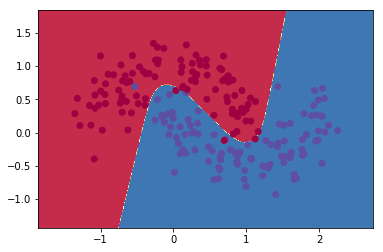

In [4]:
X, y = generate_data()
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 \
                      , nn_output_dim=2, actFun_type='tanh')
model.fit_model(X,y)
model.visualize_decision_boundary(X,y)

## Sigmoid Training

Loss after iteration 0: 0.628571
Loss after iteration 1000: 0.088431
Loss after iteration 2000: 0.079598
Loss after iteration 3000: 0.078604
Loss after iteration 4000: 0.078330
Loss after iteration 5000: 0.078233
Loss after iteration 6000: 0.078192
Loss after iteration 7000: 0.078174
Loss after iteration 8000: 0.078166
Loss after iteration 9000: 0.078161
Loss after iteration 10000: 0.078159
Loss after iteration 11000: 0.078158
Loss after iteration 12000: 0.078157
Loss after iteration 13000: 0.078156
Loss after iteration 14000: 0.078156
Loss after iteration 15000: 0.078156
Loss after iteration 16000: 0.078156
Loss after iteration 17000: 0.078156
Loss after iteration 18000: 0.078156
Loss after iteration 19000: 0.078155


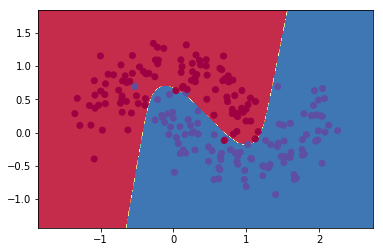

In [13]:
X, y = generate_data()
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , \
                      nn_output_dim=2, actFun_type='sigmoid')
model.fit_model(X,y)
model.visualize_decision_boundary(X,y)

## ReLU Training

Loss after iteration 0: 0.560274
Loss after iteration 1000: 0.072179
Loss after iteration 2000: 0.071301
Loss after iteration 3000: 0.071159
Loss after iteration 4000: 0.071190
Loss after iteration 5000: 0.071136
Loss after iteration 6000: 0.071276
Loss after iteration 7000: 0.071090
Loss after iteration 8000: 0.071265
Loss after iteration 9000: 0.071084
Loss after iteration 10000: 0.071090
Loss after iteration 11000: 0.071087
Loss after iteration 12000: 0.071086
Loss after iteration 13000: 0.071069
Loss after iteration 14000: 0.071114
Loss after iteration 15000: 0.071074
Loss after iteration 16000: 0.071113
Loss after iteration 17000: 0.071071
Loss after iteration 18000: 0.071090
Loss after iteration 19000: 0.071219


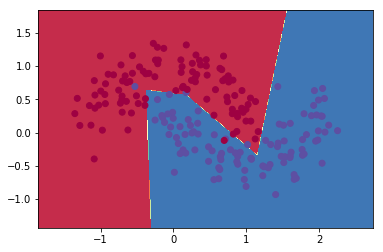

In [14]:
X, y = generate_data()
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                      nn_output_dim=2, actFun_type='relu')
model.fit_model(X,y)
model.visualize_decision_boundary(X,y)

## Qualitative Act Function Differences

Tanh got the lowest loss of all the activation functions, but the decision boundaries for tanh and sigmoid look almost identical. Even though sigmoid and tanh look very similar, sigmoid got the lowest accuracy out of all three. ReLU looks obviously different than the other two activation functions because it has sharp boundaries. 

## Changing the number of hidden units

Loss after iteration 0: 0.567280
Loss after iteration 1000: 0.333524
Loss after iteration 2000: 0.333505
Loss after iteration 3000: 0.333489
Loss after iteration 4000: 0.333476
Loss after iteration 5000: 0.333466
Loss after iteration 6000: 0.333457
Loss after iteration 7000: 0.333450
Loss after iteration 8000: 0.333444
Loss after iteration 9000: 0.333439
Loss after iteration 10000: 0.333435
Loss after iteration 11000: 0.333432
Loss after iteration 12000: 0.333430
Loss after iteration 13000: 0.333428
Loss after iteration 14000: 0.333426
Loss after iteration 15000: 0.333424
Loss after iteration 16000: 0.333423
Loss after iteration 17000: 0.333422
Loss after iteration 18000: 0.333421
Loss after iteration 19000: 0.333421


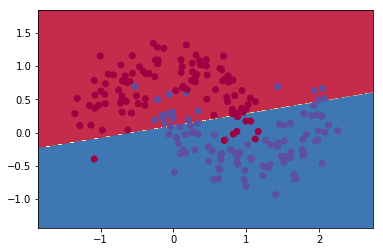

Loss after iteration 0: 0.546544
Loss after iteration 1000: 0.323426
Loss after iteration 2000: 0.316856
Loss after iteration 3000: 0.308675
Loss after iteration 4000: 0.170691
Loss after iteration 5000: 0.319894
Loss after iteration 6000: 0.323594
Loss after iteration 7000: 0.323186
Loss after iteration 8000: 0.403626
Loss after iteration 9000: 0.311026
Loss after iteration 10000: 0.321353
Loss after iteration 11000: 0.322331
Loss after iteration 12000: 0.121693
Loss after iteration 13000: 0.321422
Loss after iteration 14000: 0.324111
Loss after iteration 15000: 0.325995
Loss after iteration 16000: 0.342739
Loss after iteration 17000: 0.312904
Loss after iteration 18000: 0.305647
Loss after iteration 19000: 0.319000


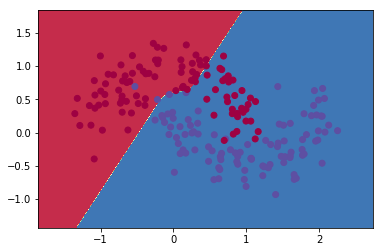

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069103
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Loss after iteration 10000: 0.070758
Loss after iteration 11000: 0.070758
Loss after iteration 12000: 0.070758
Loss after iteration 13000: 0.070758
Loss after iteration 14000: 0.070758
Loss after iteration 15000: 0.070758
Loss after iteration 16000: 0.070758
Loss after iteration 17000: 0.070758
Loss after iteration 18000: 0.070758
Loss after iteration 19000: 0.070758


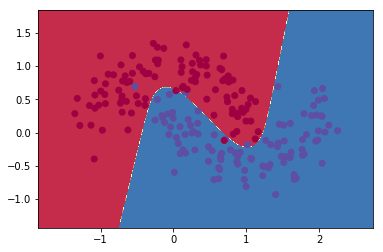

Loss after iteration 0: 0.613897
Loss after iteration 1000: 0.053880
Loss after iteration 2000: 0.044053
Loss after iteration 3000: 0.041367
Loss after iteration 4000: 0.040268
Loss after iteration 5000: 0.039732
Loss after iteration 6000: 0.039444
Loss after iteration 7000: 0.039280
Loss after iteration 8000: 0.039185
Loss after iteration 9000: 0.039128
Loss after iteration 10000: 0.039093
Loss after iteration 11000: 0.039072
Loss after iteration 12000: 0.039059
Loss after iteration 13000: 0.039050
Loss after iteration 14000: 0.039045
Loss after iteration 15000: 0.039042
Loss after iteration 16000: 0.039040
Loss after iteration 17000: 0.039038
Loss after iteration 18000: 0.039038
Loss after iteration 19000: 0.039037


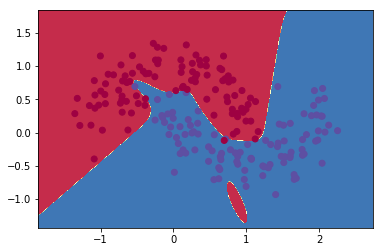

Loss after iteration 0: 0.634102
Loss after iteration 1000: 0.047377
Loss after iteration 2000: 0.038216
Loss after iteration 3000: 0.035216
Loss after iteration 4000: 0.033740
Loss after iteration 5000: 0.032800
Loss after iteration 6000: 0.032126
Loss after iteration 7000: 0.031624
Loss after iteration 8000: 0.031264
Loss after iteration 9000: 0.031044
Loss after iteration 10000: 0.030910
Loss after iteration 11000: 0.030821
Loss after iteration 12000: 0.030758
Loss after iteration 13000: 0.030711
Loss after iteration 14000: 0.030675
Loss after iteration 15000: 0.030646
Loss after iteration 16000: 0.030622
Loss after iteration 17000: 0.030601
Loss after iteration 18000: 0.030582
Loss after iteration 19000: 0.030565


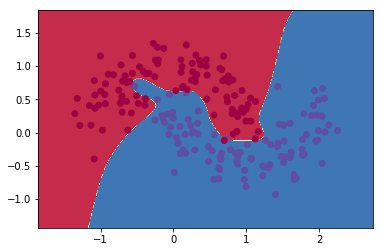

Loss after iteration 0: 3.337639
Loss after iteration 1000: 0.055917
Loss after iteration 2000: 0.051549
Loss after iteration 3000: 0.049034
Loss after iteration 4000: 0.044996
Loss after iteration 5000: 0.041430
Loss after iteration 6000: 0.039521
Loss after iteration 7000: 0.038245
Loss after iteration 8000: 0.037321
Loss after iteration 9000: 0.036611
Loss after iteration 10000: 0.036011
Loss after iteration 11000: 0.035453
Loss after iteration 12000: 0.034989
Loss after iteration 13000: 0.034534
Loss after iteration 14000: 0.034084
Loss after iteration 15000: 0.033670
Loss after iteration 16000: 0.033307
Loss after iteration 17000: 0.032995
Loss after iteration 18000: 0.032727
Loss after iteration 19000: 0.032493


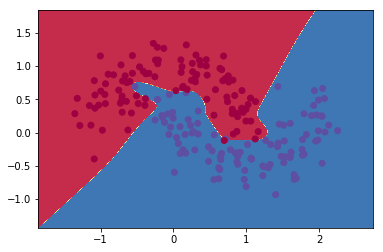

In [15]:
X, y = generate_data()

# 1 Hidden unit
model1 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=1 ,\
                       nn_output_dim=2, actFun_type='tanh')
model1.fit_model(X,y)
model1.visualize_decision_boundary(X,y)

# 2 Hidden units
model2 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=2 ,\
                       nn_output_dim=2, actFun_type='tanh')
model2.fit_model(X,y)
model2.visualize_decision_boundary(X,y)

# 3 Hidden units
model3 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                       nn_output_dim=2, actFun_type='tanh')
model3.fit_model(X,y)
model3.visualize_decision_boundary(X,y)

# 5 Hidden units
model5 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=5 ,\
                       nn_output_dim=2, actFun_type='tanh')
model5.fit_model(X,y)
model5.visualize_decision_boundary(X,y)

# 10 Hidden units
model10 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=10 ,\
                        nn_output_dim=2, actFun_type='tanh')
model10.fit_model(X,y)
model10.visualize_decision_boundary(X,y)


# 100 Hidden units
model100 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=100 ,\
                         nn_output_dim=2, actFun_type='tanh')
model100.fit_model(X,y)
model100.visualize_decision_boundary(X,y)



## Describing Differences in Hidden Units

1 and 2 units were not enough to get an accurate representation of the function and therefore they had very high losses and strange looking decision boundaries. Three units seems to have been the sweet spot since the loss went down drastically and the decision boundary looks reasonable. As you continue to increase the number of hidden units past 5, the decision boundary looks more and more like it is overfitting to the data and less like interlocking circles.

## Deep Network Configurations

### Different # of layers with Tanh

You can see from the results below that 2 layers seems to be able to fit the data pretty well with low overfitting. 3-4 layers gets half the loss but it looks like there is some overfitting. At 5 layers you can see that the training starts to slow down due to the number of parameters. For 10 and 20 layers, the training is too slow for anything reasonable to train at all.

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069103
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Loss after iteration 10000: 0.070758
Loss after iteration 11000: 0.070758
Loss after iteration 12000: 0.070758
Loss after iteration 13000: 0.070758
Loss after iteration 14000: 0.070758
Loss after iteration 15000: 0.070758
Loss after iteration 16000: 0.070758
Loss after iteration 17000: 0.070758
Loss after iteration 18000: 0.070758
Loss after iteration 19000: 0.070758


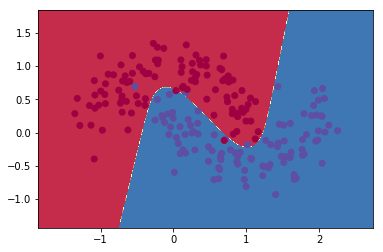

Loss after iteration 0: 0.471233
Loss after iteration 1000: 0.060126
Loss after iteration 2000: 0.059230
Loss after iteration 3000: 0.064547
Loss after iteration 4000: 0.061636
Loss after iteration 5000: 0.069500
Loss after iteration 6000: 0.061055
Loss after iteration 7000: 0.062575
Loss after iteration 8000: 0.059622
Loss after iteration 9000: 0.054221
Loss after iteration 10000: 0.046217
Loss after iteration 11000: 0.046849
Loss after iteration 12000: 0.063403
Loss after iteration 13000: 0.074524
Loss after iteration 14000: 0.101585
Loss after iteration 15000: 0.068548
Loss after iteration 16000: 0.045730
Loss after iteration 17000: 0.048865
Loss after iteration 18000: 0.045791
Loss after iteration 19000: 0.047413


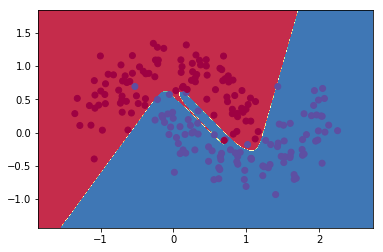

Loss after iteration 0: 0.795597
Loss after iteration 1000: 0.058132
Loss after iteration 2000: 0.059765
Loss after iteration 3000: 0.058147
Loss after iteration 4000: 0.080096
Loss after iteration 5000: 0.057794
Loss after iteration 6000: 0.050532
Loss after iteration 7000: 0.049035
Loss after iteration 8000: 0.048291
Loss after iteration 9000: 0.047934
Loss after iteration 10000: 0.046048
Loss after iteration 11000: 0.076878
Loss after iteration 12000: 0.057081
Loss after iteration 13000: 0.073288
Loss after iteration 14000: 0.088769
Loss after iteration 15000: 0.073093
Loss after iteration 16000: 0.140000
Loss after iteration 17000: 0.071168
Loss after iteration 18000: 0.053062
Loss after iteration 19000: 0.051680


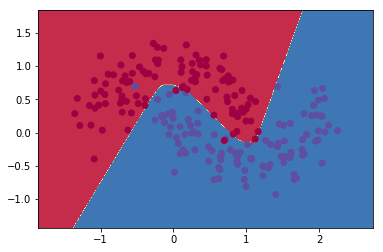

Loss after iteration 0: 0.627103
Loss after iteration 1000: 0.055752
Loss after iteration 2000: 0.057866
Loss after iteration 3000: 0.057839
Loss after iteration 4000: 0.056831
Loss after iteration 5000: 0.056063
Loss after iteration 6000: 0.060373
Loss after iteration 7000: 0.073088
Loss after iteration 8000: 0.087314
Loss after iteration 9000: 0.110955
Loss after iteration 10000: 0.081301
Loss after iteration 11000: 0.080162
Loss after iteration 12000: 0.079352
Loss after iteration 13000: 0.078688
Loss after iteration 14000: 0.083189
Loss after iteration 15000: 0.080240
Loss after iteration 16000: 0.079270
Loss after iteration 17000: 0.078584
Loss after iteration 18000: 0.077923
Loss after iteration 19000: 0.078430


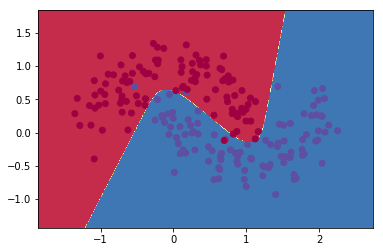

Loss after iteration 0: 0.703380
Loss after iteration 1000: 0.694301
Loss after iteration 2000: 0.694093
Loss after iteration 3000: 0.693920
Loss after iteration 4000: 0.693777
Loss after iteration 5000: 0.653076
Loss after iteration 6000: 0.416311
Loss after iteration 7000: 0.491936
Loss after iteration 8000: 0.433694
Loss after iteration 9000: 0.419174
Loss after iteration 10000: 0.418787
Loss after iteration 11000: 0.390000
Loss after iteration 12000: 0.357840
Loss after iteration 13000: 0.357487
Loss after iteration 14000: 0.450531
Loss after iteration 15000: 0.420105
Loss after iteration 16000: 0.426258
Loss after iteration 17000: 0.412711
Loss after iteration 18000: 0.359428
Loss after iteration 19000: 0.358866


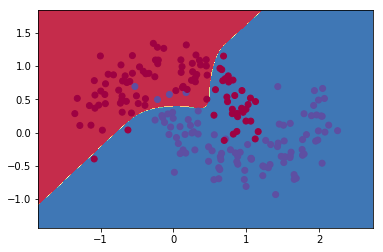

Loss after iteration 0: 0.694185
Loss after iteration 1000: 0.694700
Loss after iteration 2000: 0.694419
Loss after iteration 3000: 0.694190
Loss after iteration 4000: 0.694001
Loss after iteration 5000: 0.693847
Loss after iteration 6000: 0.693721
Loss after iteration 7000: 0.693617
Loss after iteration 8000: 0.693532
Loss after iteration 9000: 0.693462
Loss after iteration 10000: 0.693405
Loss after iteration 11000: 0.693359
Loss after iteration 12000: 0.693320
Loss after iteration 13000: 0.693289
Loss after iteration 14000: 0.693263
Loss after iteration 15000: 0.693242
Loss after iteration 16000: 0.693225
Loss after iteration 17000: 0.693211
Loss after iteration 18000: 0.693199
Loss after iteration 19000: 0.693190


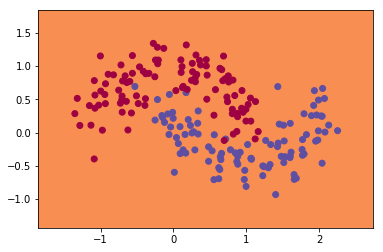

In [16]:
# 2 Layers
model2_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                                  nn_output_dim=2,n_layers=2, actFun_type='tanh')
model2_layers.fit_model(X,y)
model2_layers.visualize_decision_boundary(X,y)

# 3 layers
model3_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                                  nn_output_dim=2,n_layers=3, actFun_type='tanh')
model3_layers.fit_model(X,y)
model3_layers.visualize_decision_boundary(X,y)

# 4 layers
model4_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                                  nn_output_dim=2,n_layers=4, actFun_type='tanh')
model4_layers.fit_model(X,y)
model4_layers.visualize_decision_boundary(X,y)

# 5 layers
model5_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                                  nn_output_dim=2,n_layers=5, actFun_type='tanh')
model5_layers.fit_model(X,y)
model5_layers.visualize_decision_boundary(X,y)

# 10 layers
model10_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                                   nn_output_dim=2,n_layers=10, actFun_type='tanh')
model10_layers.fit_model(X,y)
model10_layers.visualize_decision_boundary(X,y)

# 20 layers
model20_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                                   nn_output_dim=2,n_layers=20, actFun_type='tanh')
model20_layers.fit_model(X,y)
model20_layers.visualize_decision_boundary(X,y)

###  Different # of layers with ReLU

For ReLU, I had to decrease the learning rate because relu could not learn for more complex setups with the given learning rate. It looks like the more parameters you have in your network, the lower you need the learning rate to be.
<br><br>
I varied both the number of layers and the number of hidden units per layer. For few layers and few hidden units, it created a decision boundary with a small number of edges. Increasing the number of layers decrased the loss but didn't significantly increase the number of edges in the decision boundary. Incrasing the number of units from 5 units to 20 units made significantly more edges and higher complexity. This complexity persisted as I incrased the number of layers, but also decrased in loss.

Loss after iteration 0: 0.638909
Loss after iteration 1000: 0.134100
Loss after iteration 2000: 0.096878
Loss after iteration 3000: 0.088893
Loss after iteration 4000: 0.085323
Loss after iteration 5000: 0.083325
Loss after iteration 6000: 0.082183
Loss after iteration 7000: 0.081551
Loss after iteration 8000: 0.081154
Loss after iteration 9000: 0.080864
Loss after iteration 10000: 0.080670
Loss after iteration 11000: 0.080480
Loss after iteration 12000: 0.080389
Loss after iteration 13000: 0.080321
Loss after iteration 14000: 0.080279
Loss after iteration 15000: 0.080251
Loss after iteration 16000: 0.080225
Loss after iteration 17000: 0.080213
Loss after iteration 18000: 0.080198
Loss after iteration 19000: 0.080189


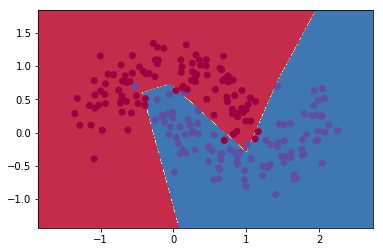

Loss after iteration 0: 0.694336
Loss after iteration 1000: 0.694306
Loss after iteration 2000: 0.058769
Loss after iteration 3000: 0.045570
Loss after iteration 4000: 0.043448
Loss after iteration 5000: 0.043086
Loss after iteration 6000: 0.043294
Loss after iteration 7000: 0.039768
Loss after iteration 8000: 0.038316
Loss after iteration 9000: 0.039013
Loss after iteration 10000: 0.048560
Loss after iteration 11000: 0.059698
Loss after iteration 12000: 0.043997
Loss after iteration 13000: 0.180033
Loss after iteration 14000: 0.202854
Loss after iteration 15000: 0.162290
Loss after iteration 16000: 0.121858
Loss after iteration 17000: 0.052235
Loss after iteration 18000: 0.057468
Loss after iteration 19000: 0.043316


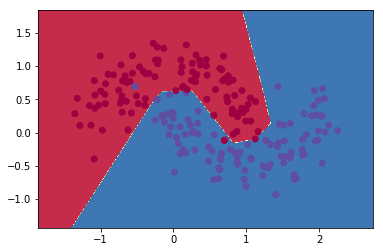

Loss after iteration 0: 0.563986
Loss after iteration 1000: 0.110038
Loss after iteration 2000: 0.073178
Loss after iteration 3000: 0.064139
Loss after iteration 4000: 0.059819
Loss after iteration 5000: 0.057090
Loss after iteration 6000: 0.055133
Loss after iteration 7000: 0.053542
Loss after iteration 8000: 0.052293
Loss after iteration 9000: 0.051242
Loss after iteration 10000: 0.050334
Loss after iteration 11000: 0.049528
Loss after iteration 12000: 0.048808
Loss after iteration 13000: 0.048189
Loss after iteration 14000: 0.047621
Loss after iteration 15000: 0.046953
Loss after iteration 16000: 0.046369
Loss after iteration 17000: 0.045856
Loss after iteration 18000: 0.045377
Loss after iteration 19000: 0.044958


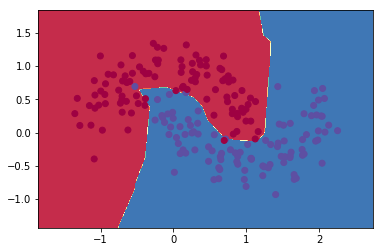

Loss after iteration 0: 0.689688
Loss after iteration 1000: 0.051622
Loss after iteration 2000: 0.025149
Loss after iteration 3000: 0.012893
Loss after iteration 4000: 0.011117
Loss after iteration 5000: 0.046055
Loss after iteration 6000: 0.016014
Loss after iteration 7000: 0.014296
Loss after iteration 8000: 0.014574
Loss after iteration 9000: 0.011471
Loss after iteration 10000: 0.014092
Loss after iteration 11000: 0.013246
Loss after iteration 12000: 0.013014
Loss after iteration 13000: 0.360121
Loss after iteration 14000: 0.015293
Loss after iteration 15000: 0.035216
Loss after iteration 16000: 0.033717
Loss after iteration 17000: 0.033554
Loss after iteration 18000: 0.033458
Loss after iteration 19000: 0.033366


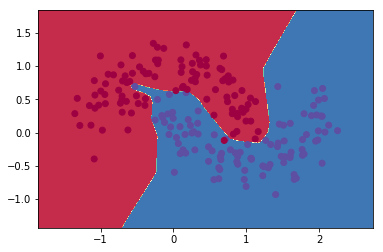

In [19]:

reg = 0.01
eps = 0.001
# 2 Layers
model2_layers = DeepNeuralNetwork(nn_input_dim=2, \
                                  nn_hidden_dim=5 , nn_output_dim=2,\
                                  n_layers=2,reg_lambda=reg, actFun_type='relu')
model2_layers.fit_model(X,y, epsilon=eps)
model2_layers.visualize_decision_boundary(X,y)

# 10 layers
model10_layers = DeepNeuralNetwork(nn_input_dim=2,\
                                   nn_hidden_dim=5 , nn_output_dim=2,\
                                   n_layers=10,reg_lambda=reg, actFun_type='relu')
model10_layers.fit_model(X,y, epsilon=eps)
model10_layers.visualize_decision_boundary(X,y)


# 2 Layers 20 units
model2_layers = DeepNeuralNetwork(nn_input_dim=2, \
                                  nn_hidden_dim=20 , nn_output_dim=2,\
                                  n_layers=2,reg_lambda=reg, actFun_type='relu')
model2_layers.fit_model(X,y, epsilon=eps)
model2_layers.visualize_decision_boundary(X,y)

# 10 layers units
model10_layers = DeepNeuralNetwork(nn_input_dim=2, \
                                   nn_hidden_dim=20 , nn_output_dim=2,\
                                   n_layers=10,reg_lambda=reg, actFun_type='relu')
model10_layers.fit_model(X,y, epsilon=eps)
model10_layers.visualize_decision_boundary(X,y)




## Training on a different dataset

This is a data set where there are two concentric and overlapping circles where the blue circle is slightly more inward than the red circle. I would expect a network that is not overfitting to color the inside of the circle blue and the outside of the circle red. Since this dataset is much more prone to overfitting, it is a much better indicator of which neural network configurations create a good generalized model.

In [10]:
def generate_circles_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_circles(200, noise=0.20)
    return X, y


## Visualizing Make Circles

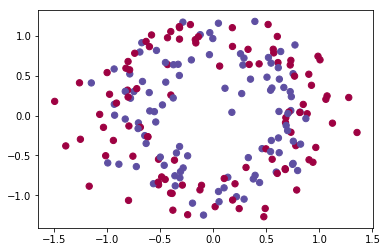

In [13]:
X, y = generate_circles_data()
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)

## Different numbers of layers on make circles

As with the moons dataset, increasing the number of layers will increase the number of lines that the decision boundary has and having too many paramaters will cause the network to overfit the data. 

Loss after iteration 0: 0.713439
Loss after iteration 1000: 0.598384
Loss after iteration 2000: 0.593382
Loss after iteration 3000: 0.593014
Loss after iteration 4000: 0.592859
Loss after iteration 5000: 0.592811
Loss after iteration 6000: 0.592796
Loss after iteration 7000: 0.592793
Loss after iteration 8000: 0.592791
Loss after iteration 9000: 0.592791
Loss after iteration 10000: 0.592792
Loss after iteration 11000: 0.592792
Loss after iteration 12000: 0.592791
Loss after iteration 13000: 0.592793
Loss after iteration 14000: 0.592787
Loss after iteration 15000: 0.592794
Loss after iteration 16000: 0.592789
Loss after iteration 17000: 0.592791
Loss after iteration 18000: 0.592790
Loss after iteration 19000: 0.592789


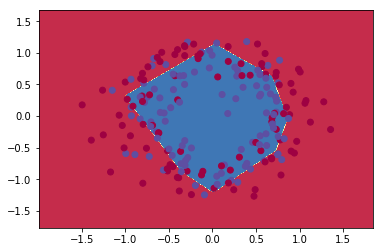

Loss after iteration 0: 0.694271
Loss after iteration 1000: 0.632334
Loss after iteration 2000: 0.685626
Loss after iteration 3000: 0.600698
Loss after iteration 4000: 0.578599
Loss after iteration 5000: 0.579061
Loss after iteration 6000: 0.634209
Loss after iteration 7000: 0.563287
Loss after iteration 8000: 0.563458
Loss after iteration 9000: 0.551540
Loss after iteration 10000: 0.574078
Loss after iteration 11000: 0.625544
Loss after iteration 12000: 0.548216
Loss after iteration 13000: 0.567913
Loss after iteration 14000: 0.598700
Loss after iteration 15000: 0.592979
Loss after iteration 16000: 0.562488
Loss after iteration 17000: 0.576057
Loss after iteration 18000: 0.558436
Loss after iteration 19000: 0.571540


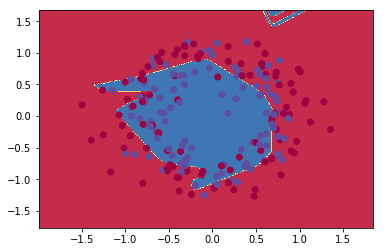

Loss after iteration 0: 0.727385
Loss after iteration 1000: 0.586623
Loss after iteration 2000: 0.584539
Loss after iteration 3000: 0.582436
Loss after iteration 4000: 0.580641
Loss after iteration 5000: 0.578544
Loss after iteration 6000: 0.576825
Loss after iteration 7000: 0.575375
Loss after iteration 8000: 0.571471
Loss after iteration 9000: 0.568853
Loss after iteration 10000: 0.566103
Loss after iteration 11000: 0.563717
Loss after iteration 12000: 0.563846
Loss after iteration 13000: 0.572846
Loss after iteration 14000: 0.571302
Loss after iteration 15000: 0.571452
Loss after iteration 16000: 0.571139
Loss after iteration 17000: 0.570576
Loss after iteration 18000: 0.571271
Loss after iteration 19000: 0.571202


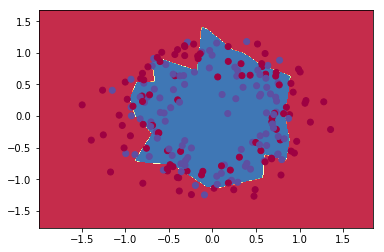

Loss after iteration 0: 0.698041
Loss after iteration 1000: 0.540368
Loss after iteration 2000: 0.456114
Loss after iteration 3000: 0.416157
Loss after iteration 4000: 0.358410
Loss after iteration 5000: 0.410999
Loss after iteration 6000: 0.313205
Loss after iteration 7000: 0.217102
Loss after iteration 8000: 0.290754
Loss after iteration 9000: 0.449548
Loss after iteration 10000: 0.275402
Loss after iteration 11000: 0.164025
Loss after iteration 12000: 0.187437
Loss after iteration 13000: 0.140453
Loss after iteration 14000: 0.400717
Loss after iteration 15000: 0.235041
Loss after iteration 16000: 0.252181
Loss after iteration 17000: 0.218335
Loss after iteration 18000: 0.193061
Loss after iteration 19000: 0.232068


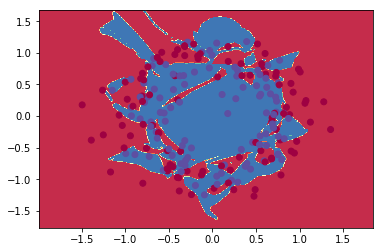

In [14]:
reg = 0.01
eps = 0.001
# 2 Layers
model2_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=5 \
                                  , nn_output_dim=2,n_layers=2,\
                                  reg_lambda=reg, actFun_type='relu')
model2_layers.fit_model(X,y, epsilon=eps)
model2_layers.visualize_decision_boundary(X,y)

# 10 layers
model10_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=5 , \
                                   nn_output_dim=2,n_layers=10,\
                                   reg_lambda=reg, actFun_type='relu')
model10_layers.fit_model(X,y, epsilon=eps)
model10_layers.visualize_decision_boundary(X,y)


# 2 Layers 20 units
model2_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=20 , \
                                  nn_output_dim=2,n_layers=2,\
                                  reg_lambda=reg, actFun_type='relu')
model2_layers.fit_model(X,y, epsilon=eps)
model2_layers.visualize_decision_boundary(X,y)

# 10 layers units
model10_layers = DeepNeuralNetwork(nn_input_dim=2, nn_hidden_dim=20 ,\
                                   nn_output_dim=2,n_layers=10,\
                                   reg_lambda=reg, actFun_type='relu')
model10_layers.fit_model(X,y, epsilon=eps)
model10_layers.visualize_decision_boundary(X,y)

## Different number of units on make_circles with tanh

With a very low number of units, the data could not be fit at all. After increasing the number of units past 3, the extra units did not have a noticeable effect on decision boundary.

Loss after iteration 0: 0.718066
Loss after iteration 1000: 0.677909
Loss after iteration 2000: 0.677016
Loss after iteration 3000: 0.676755
Loss after iteration 4000: 0.676648
Loss after iteration 5000: 0.676595
Loss after iteration 6000: 0.676564
Loss after iteration 7000: 0.676545
Loss after iteration 8000: 0.676532
Loss after iteration 9000: 0.676524
Loss after iteration 10000: 0.676518
Loss after iteration 11000: 0.676513
Loss after iteration 12000: 0.676510
Loss after iteration 13000: 0.676507
Loss after iteration 14000: 0.676505
Loss after iteration 15000: 0.676503
Loss after iteration 16000: 0.676502
Loss after iteration 17000: 0.676501
Loss after iteration 18000: 0.676500
Loss after iteration 19000: 0.676499


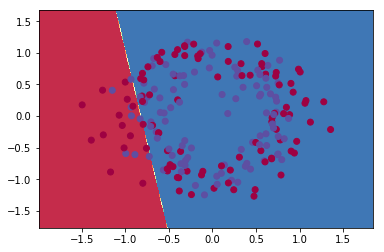

Loss after iteration 0: 0.753182
Loss after iteration 1000: 0.671201
Loss after iteration 2000: 0.664999
Loss after iteration 3000: 0.665032
Loss after iteration 4000: 0.665128
Loss after iteration 5000: 0.665226
Loss after iteration 6000: 0.665314
Loss after iteration 7000: 0.665389
Loss after iteration 8000: 0.665452
Loss after iteration 9000: 0.665505
Loss after iteration 10000: 0.665548
Loss after iteration 11000: 0.665584
Loss after iteration 12000: 0.665614
Loss after iteration 13000: 0.665639
Loss after iteration 14000: 0.665659
Loss after iteration 15000: 0.665676
Loss after iteration 16000: 0.665690
Loss after iteration 17000: 0.665702
Loss after iteration 18000: 0.665712
Loss after iteration 19000: 0.665720


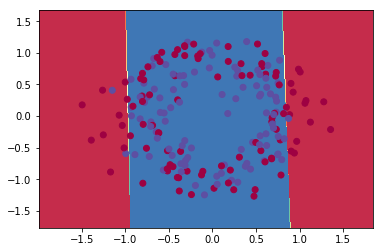

Loss after iteration 0: 0.694497
Loss after iteration 1000: 0.602654
Loss after iteration 2000: 0.601673
Loss after iteration 3000: 0.601613
Loss after iteration 4000: 0.601607
Loss after iteration 5000: 0.601606
Loss after iteration 6000: 0.601605
Loss after iteration 7000: 0.601604
Loss after iteration 8000: 0.601604
Loss after iteration 9000: 0.601603
Loss after iteration 10000: 0.601603
Loss after iteration 11000: 0.601603
Loss after iteration 12000: 0.601602
Loss after iteration 13000: 0.601602
Loss after iteration 14000: 0.601602
Loss after iteration 15000: 0.601602
Loss after iteration 16000: 0.601602
Loss after iteration 17000: 0.601601
Loss after iteration 18000: 0.601601
Loss after iteration 19000: 0.601601


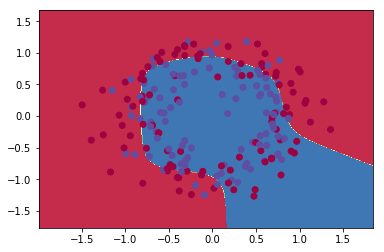

Loss after iteration 0: 0.706849
Loss after iteration 1000: 0.619366
Loss after iteration 2000: 0.611282
Loss after iteration 3000: 0.611216
Loss after iteration 4000: 0.611174
Loss after iteration 5000: 0.610700
Loss after iteration 6000: 0.610212
Loss after iteration 7000: 0.609860
Loss after iteration 8000: 0.609615
Loss after iteration 9000: 0.609442
Loss after iteration 10000: 0.609316
Loss after iteration 11000: 0.609223
Loss after iteration 12000: 0.609154
Loss after iteration 13000: 0.609101
Loss after iteration 14000: 0.609061
Loss after iteration 15000: 0.609029
Loss after iteration 16000: 0.609005
Loss after iteration 17000: 0.608985
Loss after iteration 18000: 0.608970
Loss after iteration 19000: 0.608958


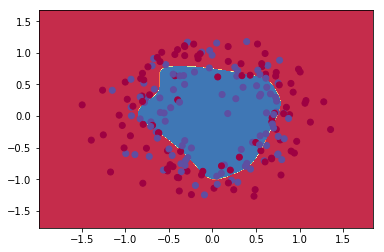

Loss after iteration 0: 0.707952
Loss after iteration 1000: 0.615701
Loss after iteration 2000: 0.593212
Loss after iteration 3000: 0.598152
Loss after iteration 4000: 0.601171
Loss after iteration 5000: 0.600164
Loss after iteration 6000: 0.603781
Loss after iteration 7000: 0.605426
Loss after iteration 8000: 0.616629
Loss after iteration 9000: 0.620585
Loss after iteration 10000: 0.606570
Loss after iteration 11000: 0.599341
Loss after iteration 12000: 0.615443
Loss after iteration 13000: 0.600945
Loss after iteration 14000: 0.605265
Loss after iteration 15000: 0.604936
Loss after iteration 16000: 0.600828
Loss after iteration 17000: 0.599970
Loss after iteration 18000: 0.601814
Loss after iteration 19000: 0.605630


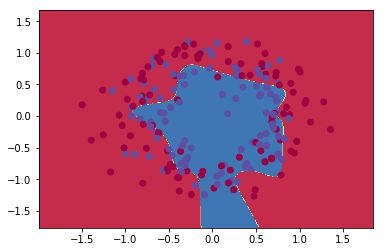

Loss after iteration 0: 2.782843
Loss after iteration 1000: 0.619131
Loss after iteration 2000: 0.592477
Loss after iteration 3000: 0.583304
Loss after iteration 4000: 0.584427
Loss after iteration 5000: 0.584182
Loss after iteration 6000: 0.582656
Loss after iteration 7000: 0.581086
Loss after iteration 8000: 0.579474
Loss after iteration 9000: 0.581392
Loss after iteration 10000: 0.580224
Loss after iteration 11000: 0.579669
Loss after iteration 12000: 0.581265
Loss after iteration 13000: 0.578905
Loss after iteration 14000: 0.579357
Loss after iteration 15000: 0.578042
Loss after iteration 16000: 0.577534
Loss after iteration 17000: 0.577201
Loss after iteration 18000: 0.579399
Loss after iteration 19000: 0.577028


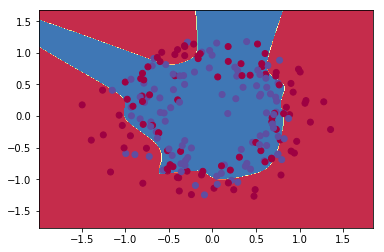

In [15]:
# 1 Hidden unit
model1 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=1 , \
                       nn_output_dim=2, actFun_type='tanh')
model1.fit_model(X,y)
model1.visualize_decision_boundary(X,y)

# 2 Hidden units
model2 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=2 ,\
                       nn_output_dim=2, actFun_type='tanh')
model2.fit_model(X,y)
model2.visualize_decision_boundary(X,y)

# 3 Hidden units
model3 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 ,\
                       nn_output_dim=2, actFun_type='tanh')
model3.fit_model(X,y)
model3.visualize_decision_boundary(X,y)

# 5 Hidden units
model5 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=5 ,\
                       nn_output_dim=2, actFun_type='tanh')
model5.fit_model(X,y)
model5.visualize_decision_boundary(X,y)

# 10 Hidden units
model10 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=10 ,\
                        nn_output_dim=2, actFun_type='tanh')
model10.fit_model(X,y)
model10.visualize_decision_boundary(X,y)


# 100 Hidden units
model100 = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=100 ,\
                         nn_output_dim=2, actFun_type='tanh')
model100.fit_model(X,y)
model100.visualize_decision_boundary(X,y)

# Homework 1 Problem 2 Code

## Default run

In [1]:
__author__ = 'tan_nguyen'

import os
import time

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Import Tensorflow and start a session
import tensorflow as tf
sess = tf.InteractiveSession()

def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    return W

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    b = tf.Variable(tf.constant(0.1, shape=shape))
    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters =
    the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the 
    filters, a.k.a. the results after convolution
    '''

    # IMPLEMENT YOUR CONV2D HERE

    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def main():

    result_dir = './results/' 
    max_step = 5500 

    start_time = time.time() # start timing

    # placeholders for input data and input labeles
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])

    # reshape the input image
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # first convolutional layer
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    tf.summary.histogram("Layer_1_Input", x_image)
    tf.summary.histogram("Layer_1_Weights", W_conv1)
    tf.summary.histogram("Layer_1_Bias", b_conv1)
    tf.summary.histogram("Layer_1_Activations", h_conv1)
    tf.summary.histogram("Layer_1_Pooling", h_pool1)

    # second convolutional layer
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    tf.summary.histogram("Layer_2_Input", h_pool1)
    tf.summary.histogram("Layer_2_Weights", W_conv2)
    tf.summary.histogram("Layer_2_Bias", b_conv2)
    tf.summary.histogram("Layer_2_Activations", h_conv2)
    tf.summary.histogram("Layer_2_Pooling", h_pool2)

    # densely connected layer
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
    tf.summary.histogram("fc1_Inputs", h_pool2)
    tf.summary.histogram("fc1_Weights", W_fc1)
    tf.summary.histogram("fc1_Biases", b_fc1)
    tf.summary.histogram("fc1_Activations", h_fc1)
    tf.summary.histogram("fc1_Pool", h_pool2_flat)

    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # softmax
    W_fc2 = weight_variable([1024, 10])  
    b_fc2 = bias_variable([10])
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')
    
    tf.summary.histogram("h_fc1_drop", h_pool2)
    tf.summary.histogram("fc2_Weights", W_fc2)
    tf.summary.histogram("fc2_Biases", b_fc2)
    tf.summary.histogram("fc2_Activations", y_conv)

    # setup training
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ \
                            * tf.log(y_conv), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,\
                                      tf.float32), name='accuracy')

    # Add a scalar summary for the snapshot loss.
    tf.summary.scalar(cross_entropy.op.name, cross_entropy)
    
    # Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()
    
    validation_acc_summary = tf.summary.scalar('validation_accuracy', accuracy)
    test_acc_summary = tf.summary.scalar('test_accuracy', accuracy)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()

    # Instantiate a SummaryWriter to output summaries and the Graph.
    summary_writer = tf.summary.FileWriter(result_dir, sess.graph)

    # Run the Op to initialize the variables.
    sess.run(init)

    # run the training
    for i in range(max_step):
        batch = mnist.train.next_batch(50) 
        if i%100 == 0:
            # output the training accuracy every 100 iterations
            train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y_:batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))

            summary_str = sess.run(summary_op, feed_dict\
                                   ={x: batch[0], \
                                     y_: batch[1], keep_prob: 0.5})
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()

        # save the checkpoints every 1100 iterations
        if i % 1100 == 0 or i == max_step:
            checkpoint_file = os.path.join(result_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=i)
            test_accuracy = sess.run(test_acc_summary, feed_dict=\
                            {x: mnist.test.images, \
                             y_: mnist.test.labels, keep_prob: 1.0})
            validation_accuracy = sess.run(validation_acc_summary, feed_dict=\
                            {x: mnist.validation.images, \
                             y_: mnist.validation.labels, keep_prob: 1.0})
            summary_writer.add_summary(test_accuracy, i)
            summary_writer.add_summary(validation_accuracy, i)

        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
    # print/log test error
    print("test accuracy %g"%accuracy.eval(feed_dict=\
                                {x: mnist.test.images, \
                                y_: mnist.test.labels, keep_prob: 1.0}))

    stop_time = time.time()
    print('The training takes %f second to finish'%(stop_time - start_time))

if __name__ == "__main__":
    main()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.14
step 100, training accuracy 0.92
step 200, training accuracy 0.9
step 300, training accuracy 0.92
step 400, training accuracy 0.9
step 500, training accuracy 0.94
step 600, training accuracy 0.94


### Tensorboard results

Populating the interactive namespace from numpy and matplotlib


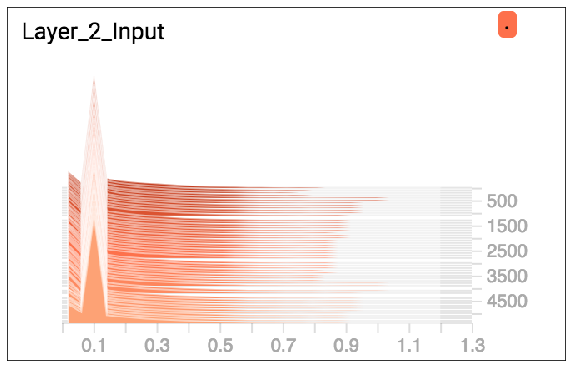

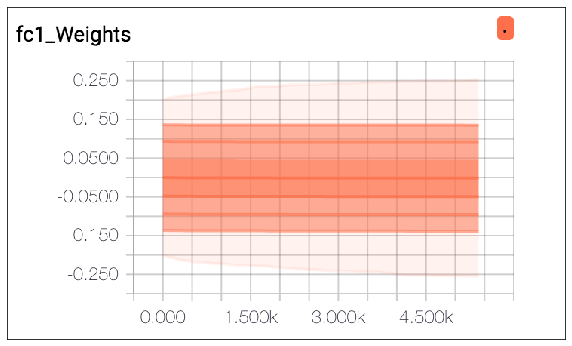

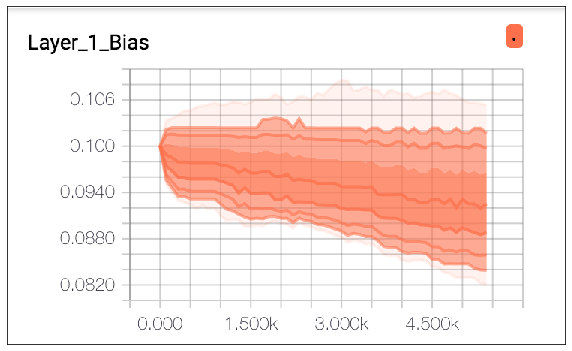

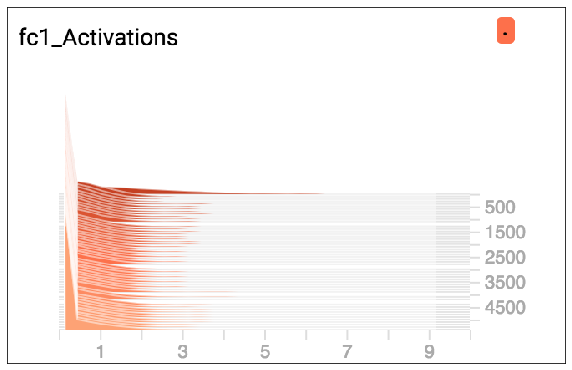

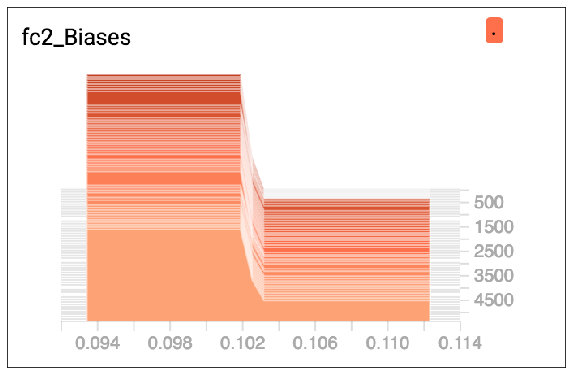

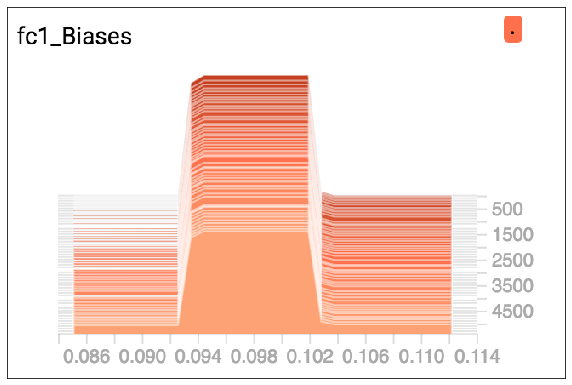

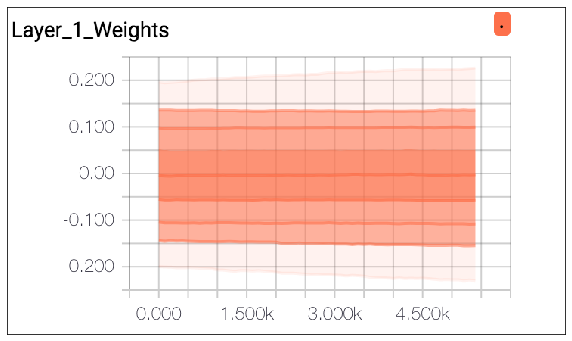

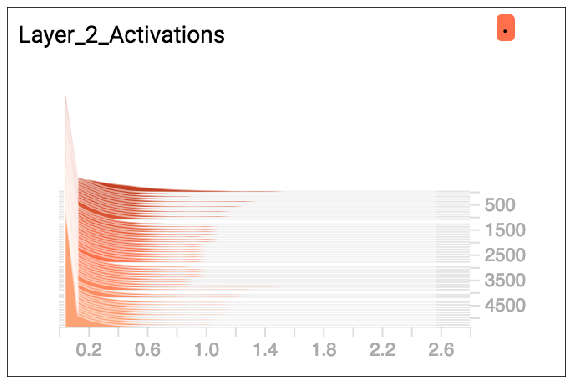

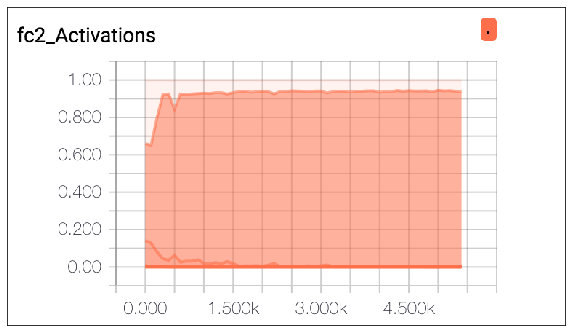

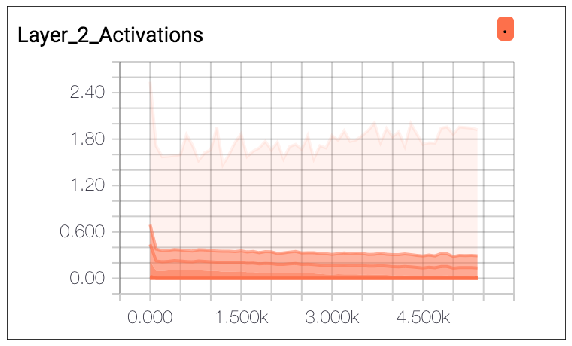

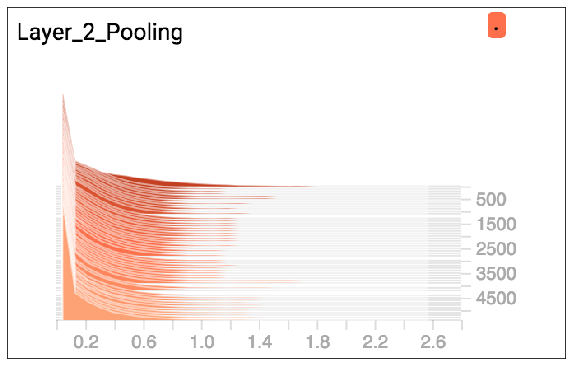

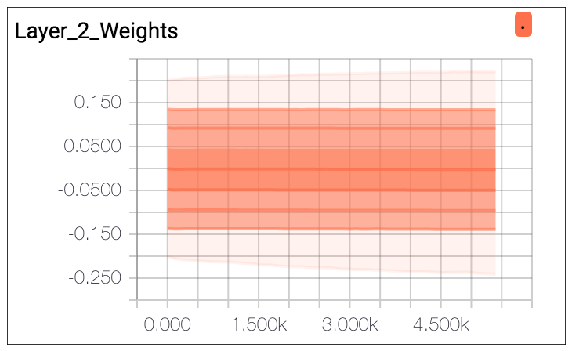

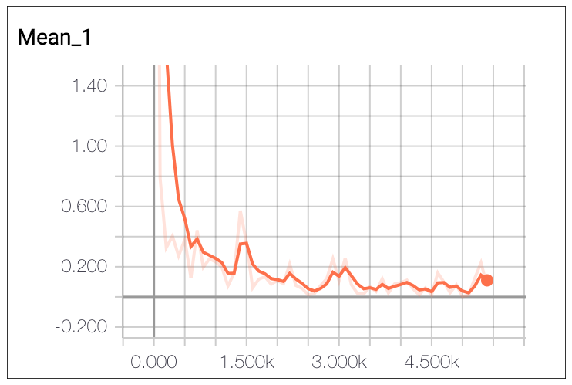

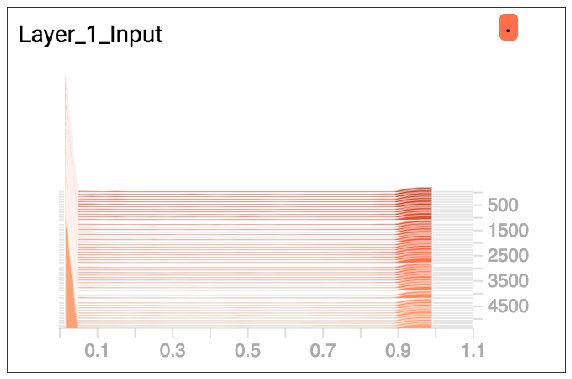

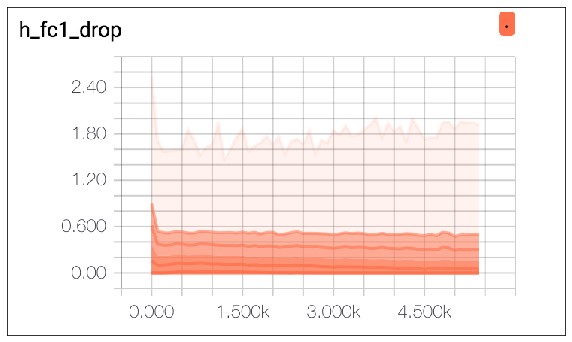

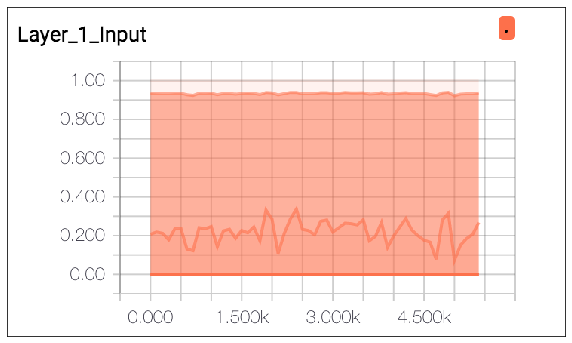

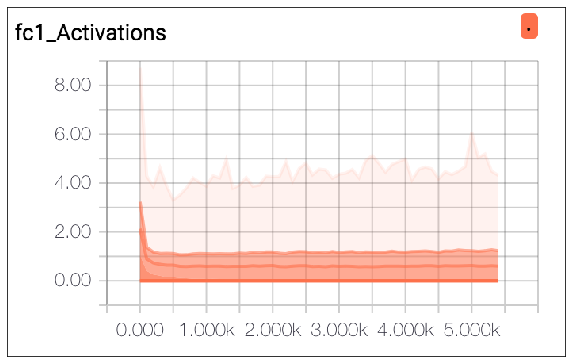

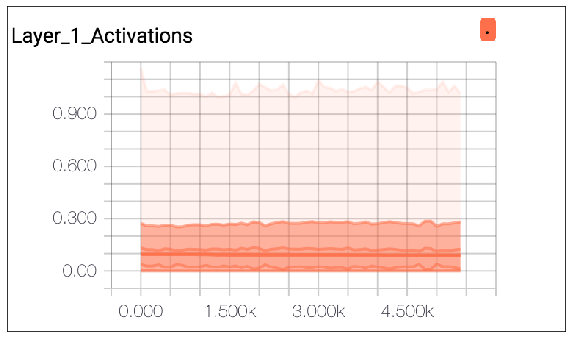

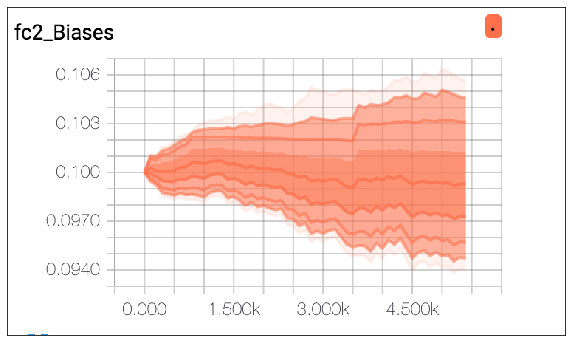

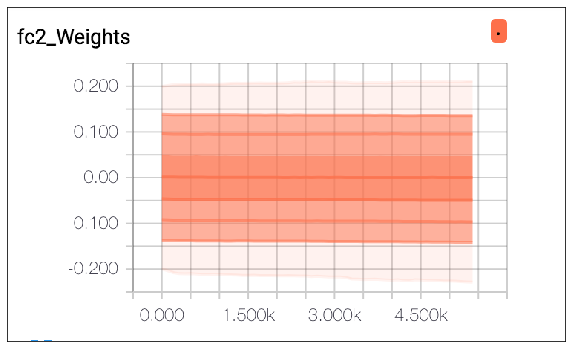

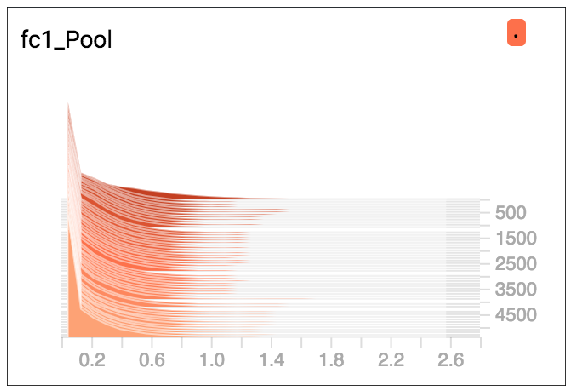

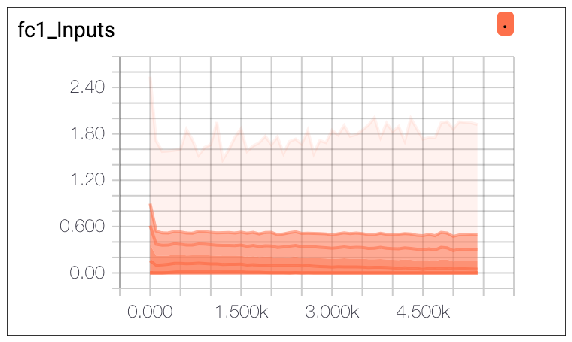

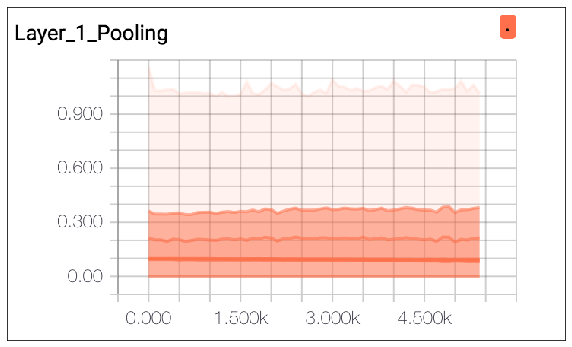

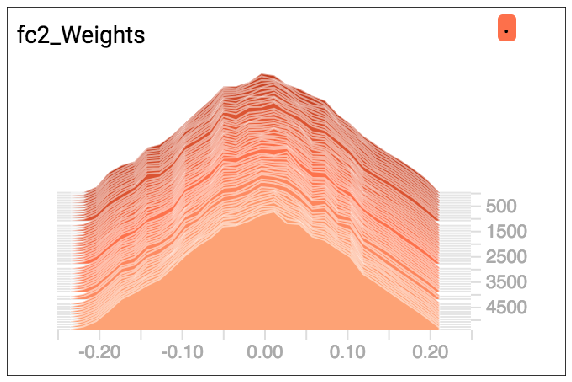

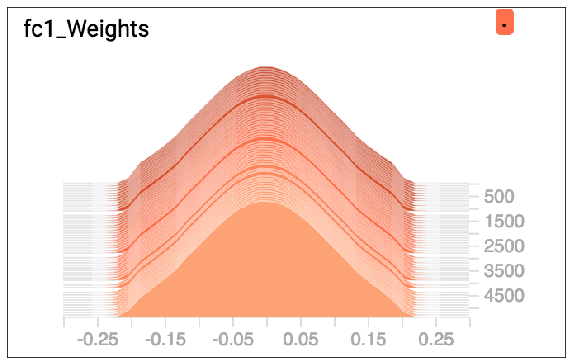

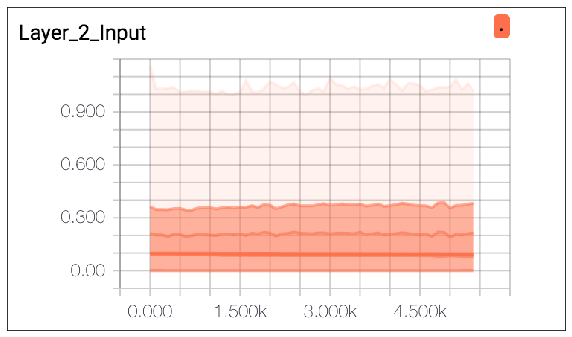

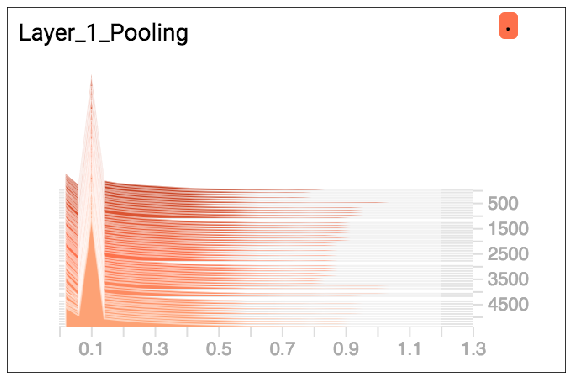

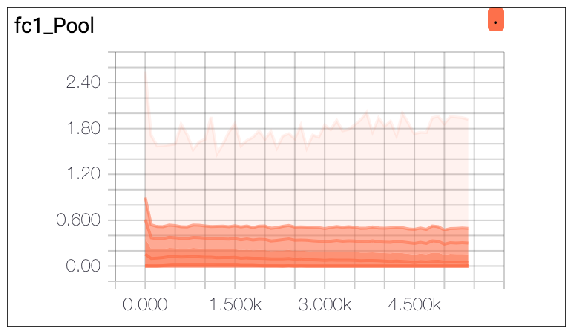

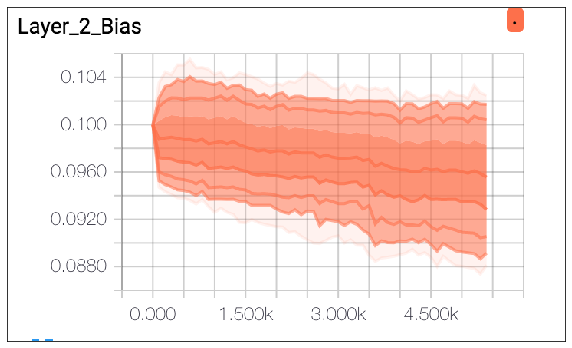

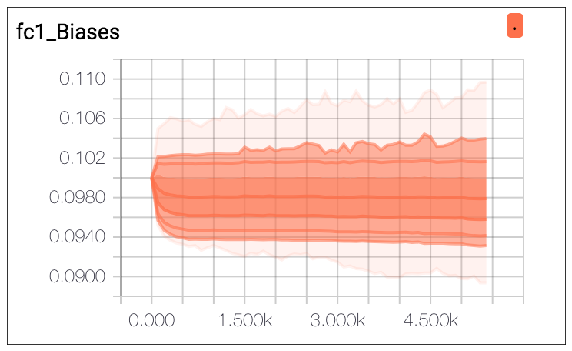

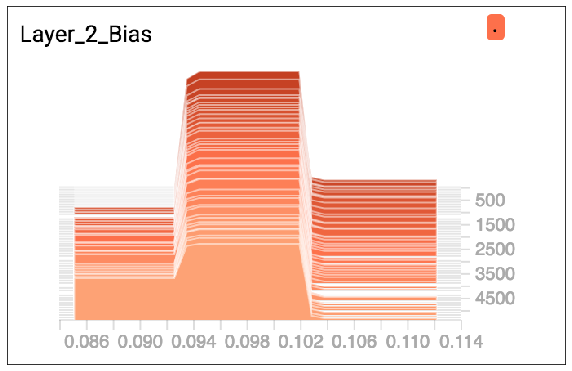

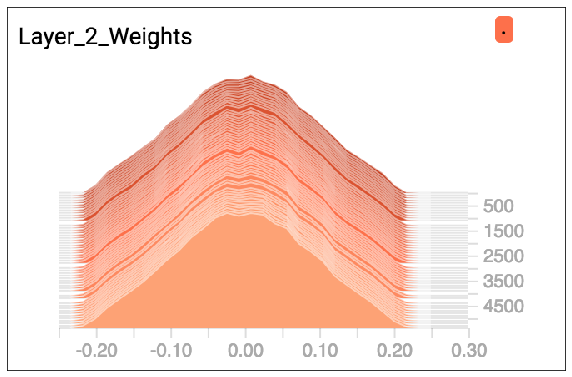

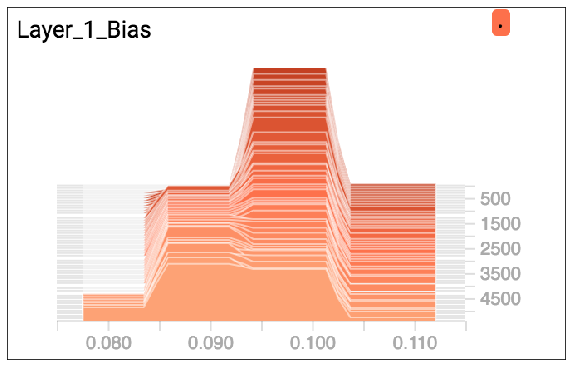

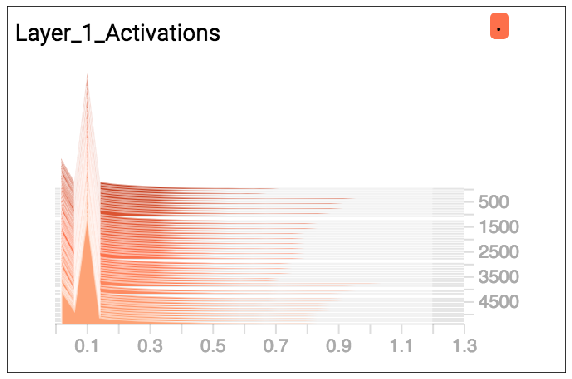

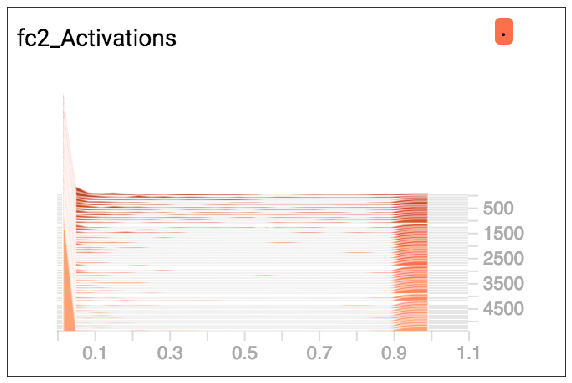

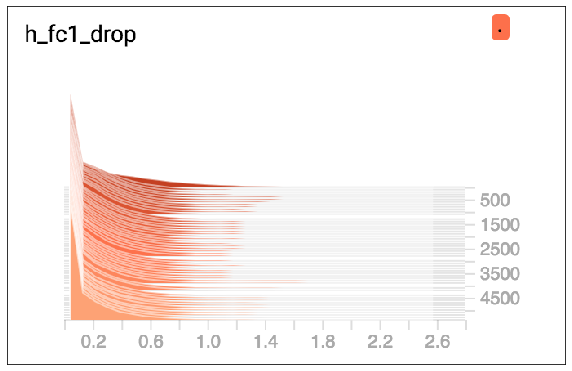

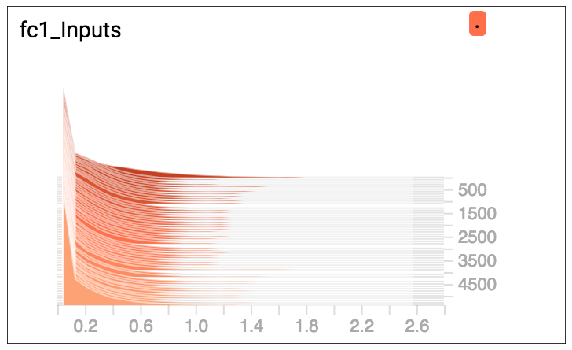

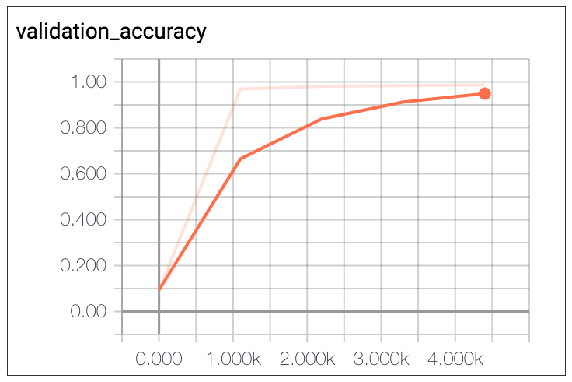

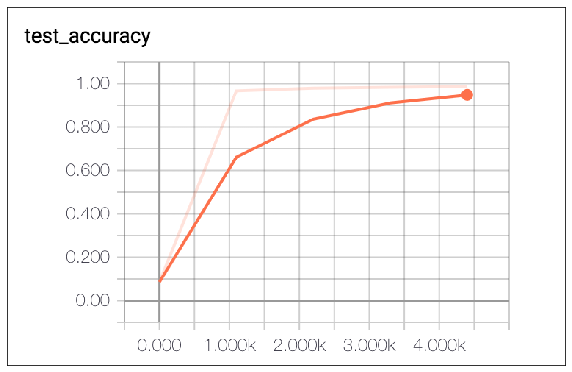

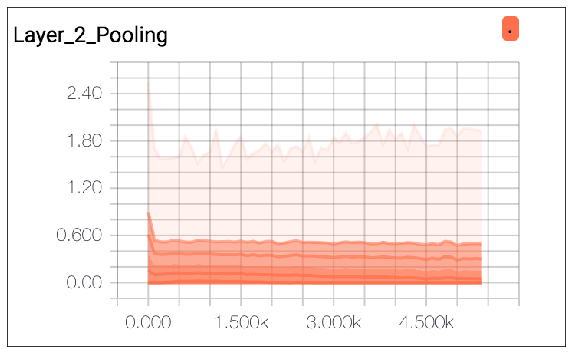

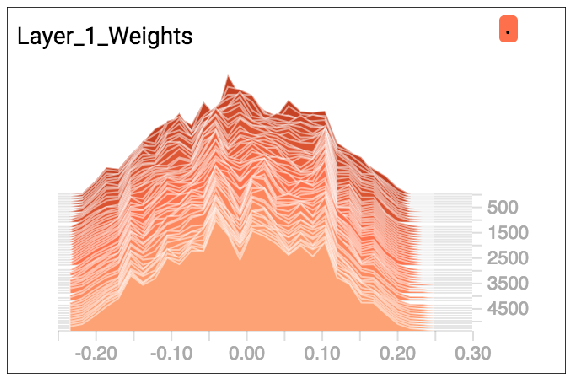

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
%pylab inline
arr = os.listdir("./images/run_1")
for file in arr:
    img=mpimg.imread("./images/run_1/"+file)
    figure(figsize = (10,10))
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()


## Alternate Run Number 1 with tanh and random initialization

In [7]:
__author__ = 'tan_nguyen'

import os
import time

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Import Tensorflow and start a session
import tensorflow as tf
sess = tf.InteractiveSession()

def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''
    W = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    return W

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''

    b = tf.Variable(tf.constant(0.1, shape=shape))
    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters =
    the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the 
    filters, a.k.a. the results after convolution
    '''

    # IMPLEMENT YOUR CONV2D HERE

    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''

    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def main():
    result_dir = './results/' 
    max_step = 5500 

    start_time = time.time() # start timing

    # placeholders for input data and input labeles
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])

    # reshape the input image
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # first convolutional layer
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.tanh(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    tf.summary.histogram("Layer_1_Input", x_image)
    tf.summary.histogram("Layer_1_Weights", W_conv1)
    tf.summary.histogram("Layer_1_Bias", b_conv1)
    tf.summary.histogram("Layer_1_Activations", h_conv1)
    tf.summary.histogram("Layer_1_Pooling", h_pool1)

    # second convolutional layer
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.tanh(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    tf.summary.histogram("Layer_2_Input", h_pool1)
    tf.summary.histogram("Layer_2_Weights", W_conv2)
    tf.summary.histogram("Layer_2_Bias", b_conv2)
    tf.summary.histogram("Layer_2_Activations", h_conv2)
    tf.summary.histogram("Layer_2_Pooling", h_pool2)

    # densely connected layer
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.tanh(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
    tf.summary.histogram("fc1_Inputs", h_pool2)
    tf.summary.histogram("fc1_Weights", W_fc1)
    tf.summary.histogram("fc1_Biases", b_fc1)
    tf.summary.histogram("fc1_Activations", h_fc1)
    tf.summary.histogram("fc1_Pool", h_pool2_flat)

    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # softmax
    W_fc2 = weight_variable([1024, 10])  
    b_fc2 = bias_variable([10])
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')
    
    tf.summary.histogram("h_fc1_drop", h_pool2)
    tf.summary.histogram("fc2_Weights", W_fc2)
    tf.summary.histogram("fc2_Biases", b_fc2)
    tf.summary.histogram("fc2_Activations", y_conv)

    # setup training
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ \
                            * tf.log(y_conv), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, \
                            tf.float32), name='accuracy')

    # Add a scalar summary for the snapshot loss.
    tf.summary.scalar(cross_entropy.op.name, cross_entropy)
    
    # Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()
    
    validation_acc_summary = tf.summary.scalar('validation_accuracy', accuracy)
    test_acc_summary = tf.summary.scalar('test_accuracy', accuracy)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()

    # Instantiate a SummaryWriter to output summaries and the Graph.
    summary_writer = tf.summary.FileWriter(result_dir, sess.graph)

    # Run the Op to initialize the variables.
    sess.run(init)

    # run the training
    for i in range(max_step):
        batch = mnist.train.next_batch(50) 
        if i%100 == 0:
            # output the training accuracy every 100 iterations
            train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y_:batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))

            summary_str = sess.run(summary_op, feed_dict\
                                   ={x: batch[0], \
                                     y_: batch[1], keep_prob: 0.5})
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()

        # save the checkpoints every 1100 iterations
        if i % 1100 == 0 or i == max_step:
            checkpoint_file = os.path.join(result_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=i)
            test_accuracy = sess.run(test_acc_summary, feed_dict=\
                                    {x: mnist.test.images, \
                                    y_: mnist.test.labels, keep_prob: 1.0})
            validation_accuracy = sess.run(validation_acc_summary, feed_dict=\
                                    {x: mnist.validation.images, \
                                    y_: mnist.validation.labels, keep_prob: 1.0})
            summary_writer.add_summary(test_accuracy, i)
            summary_writer.add_summary(validation_accuracy, i)

        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
    # print/log test error
    print("test accuracy %g"%accuracy.eval(feed_dict=\
                                    {x: mnist.test.images,\
                                    y_: mnist.test.labels, keep_prob: 1.0}))

    stop_time = time.time()
    print('The training takes %f second to finish'%(stop_time - start_time))

if __name__ == "__main__":
    main()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.04
step 100, training accuracy 0.8
step 200, training accuracy 0.92
step 300, training accuracy 0.9
step 400, training accuracy 0.94
step 500, training accuracy 0.94
step 600, training accuracy 0.96


Populating the interactive namespace from numpy and matplotlib


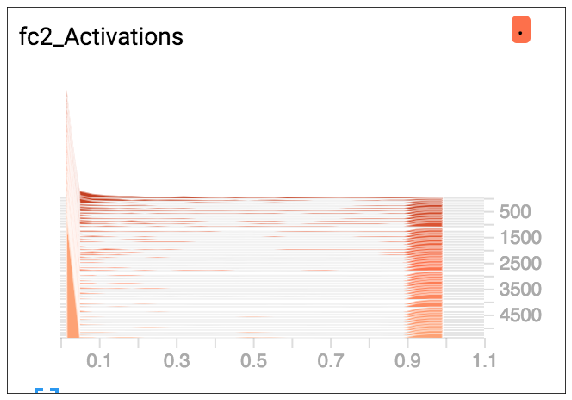

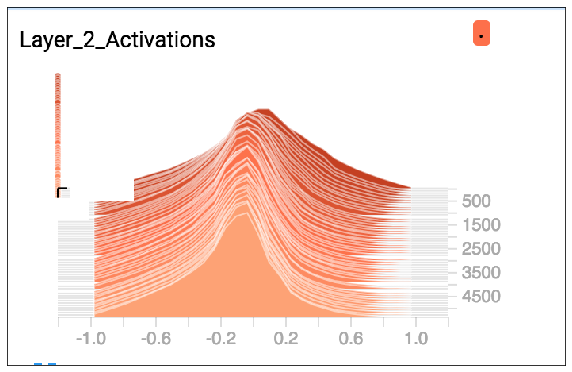

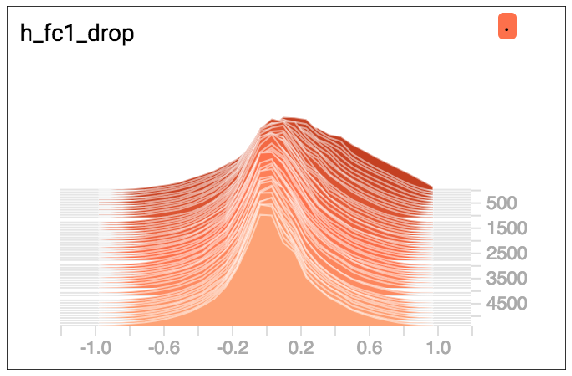

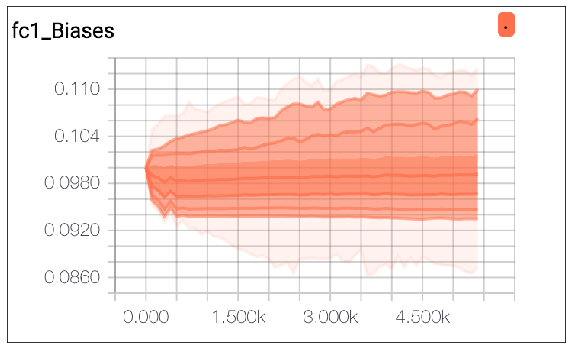

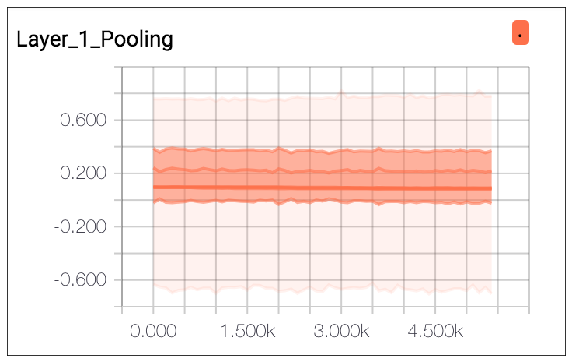

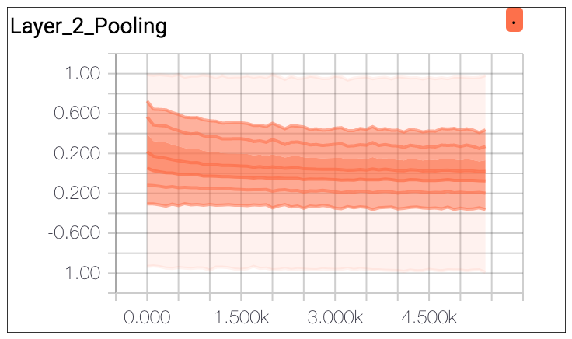

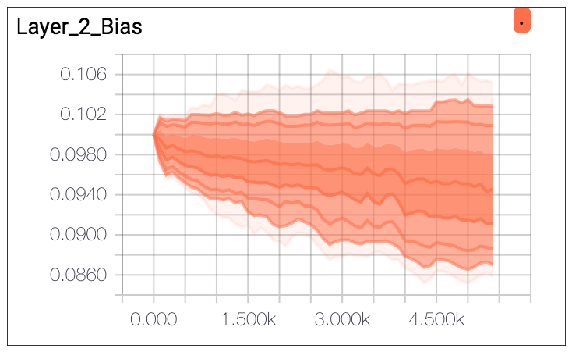

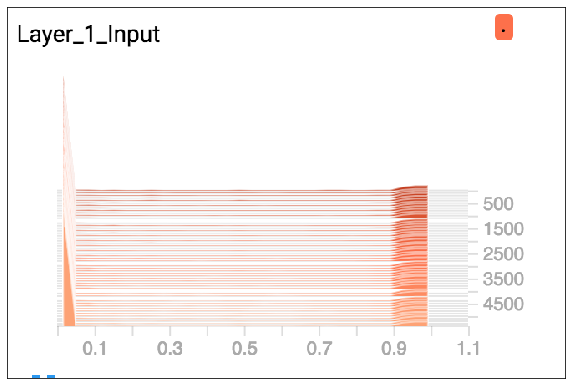

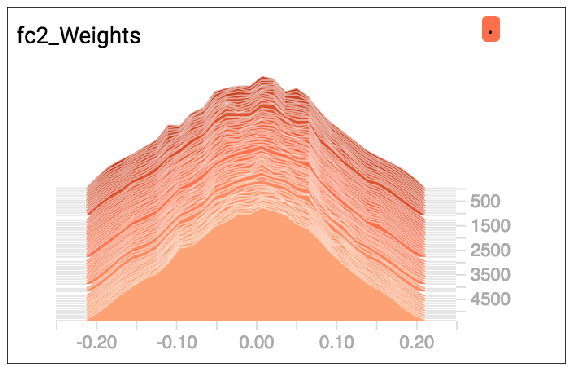

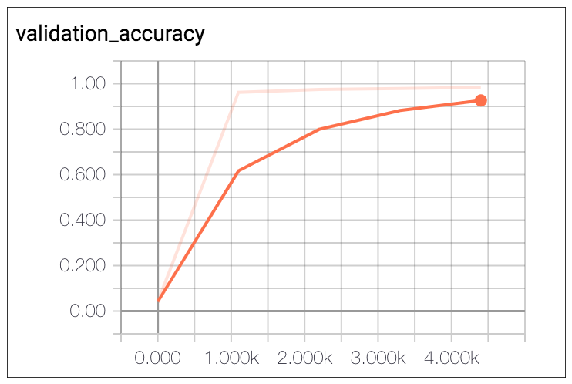

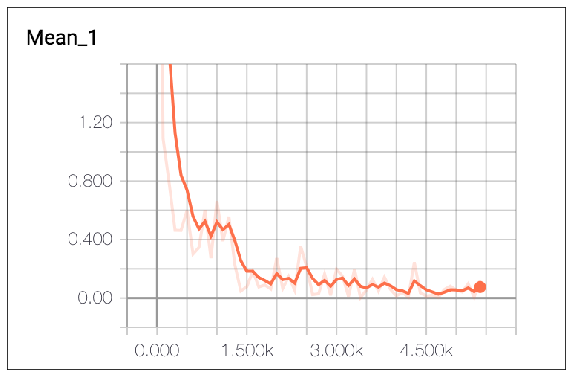

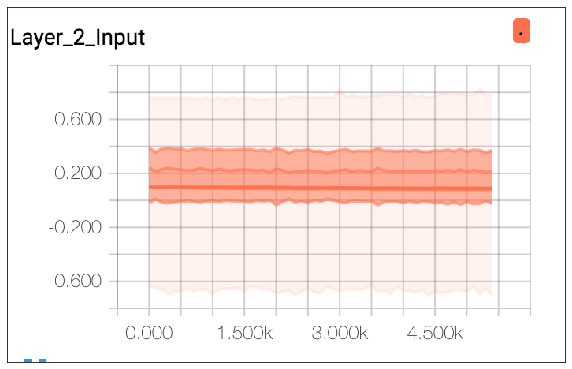

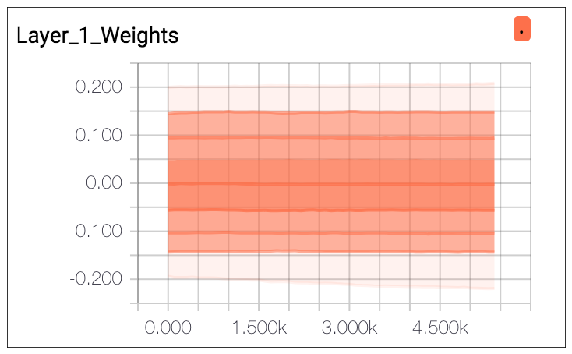

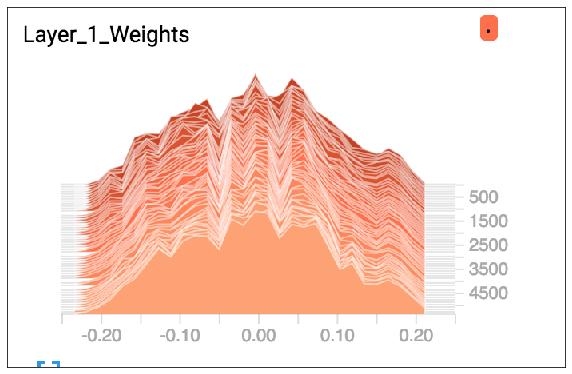

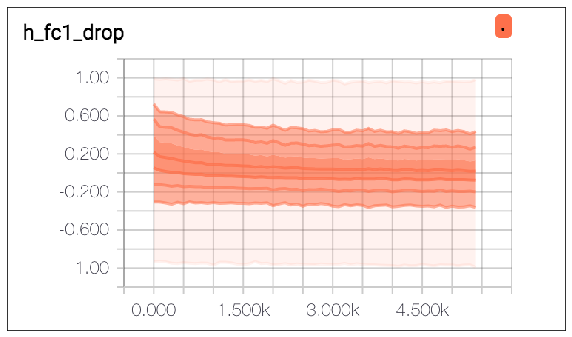

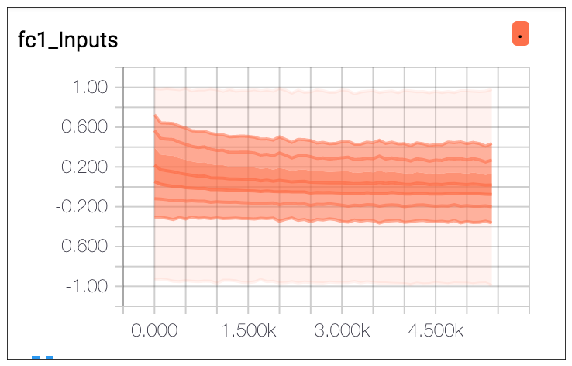

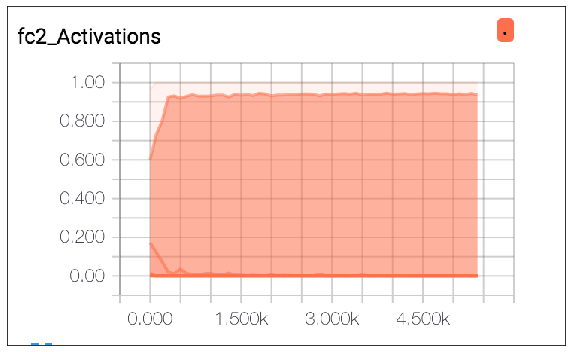

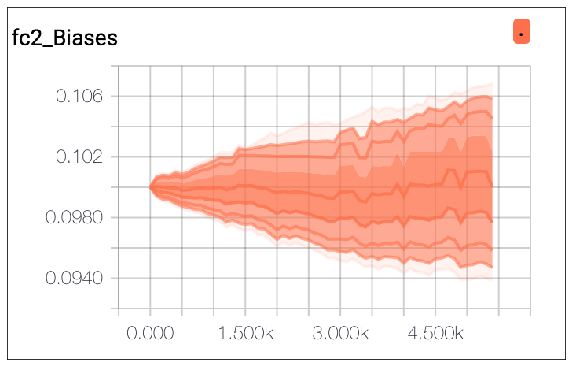

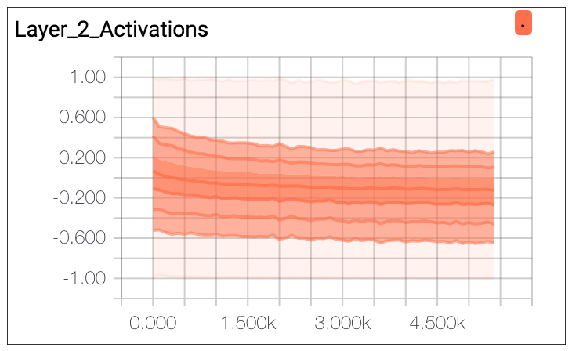

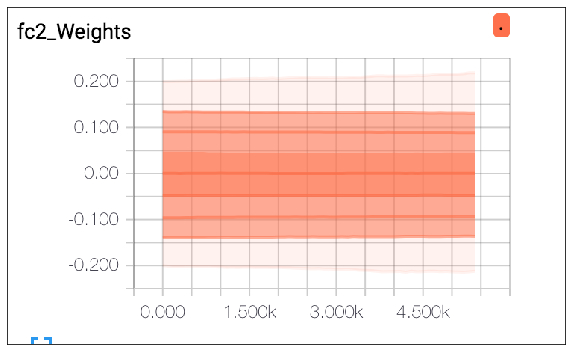

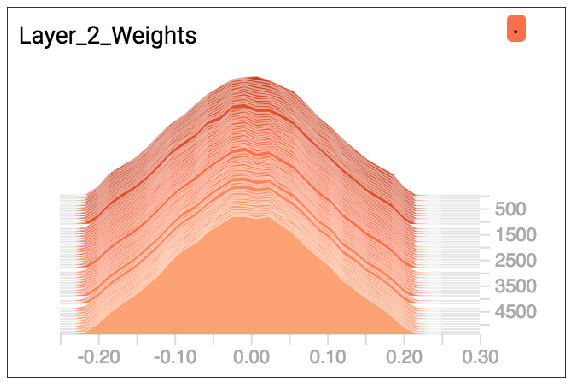

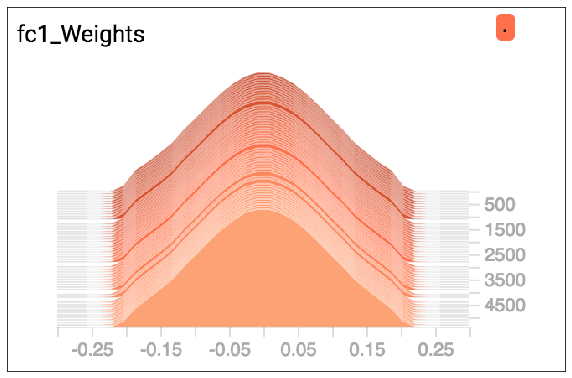

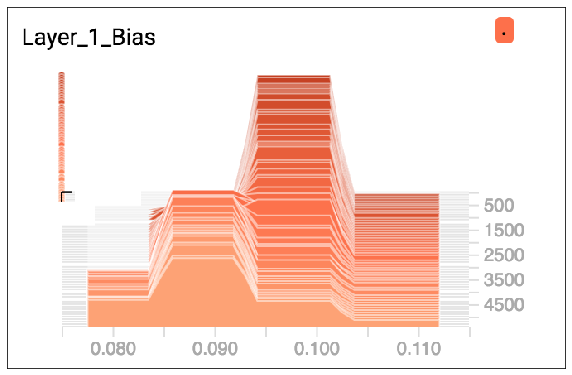

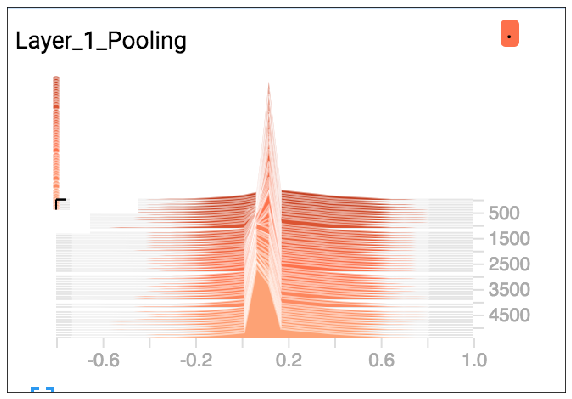

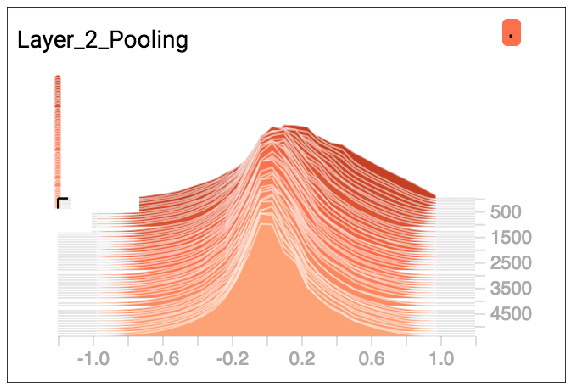

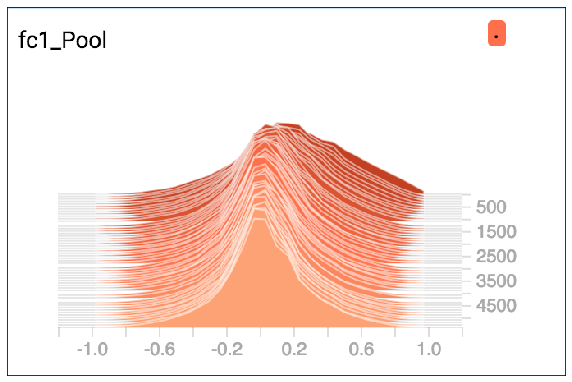

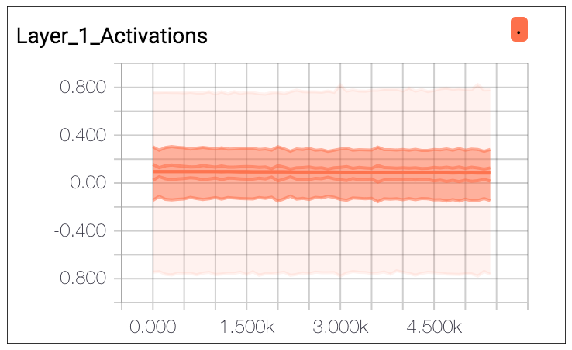

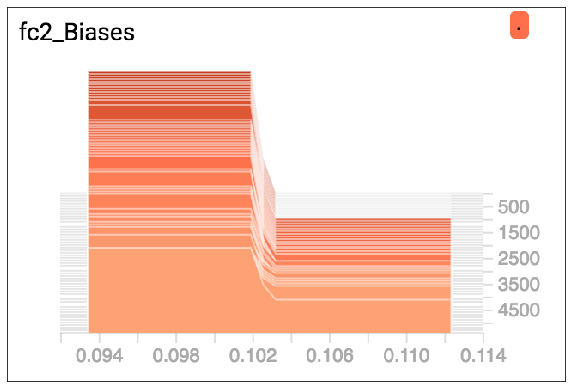

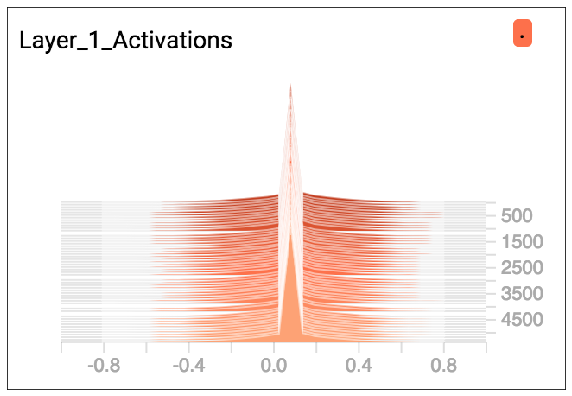

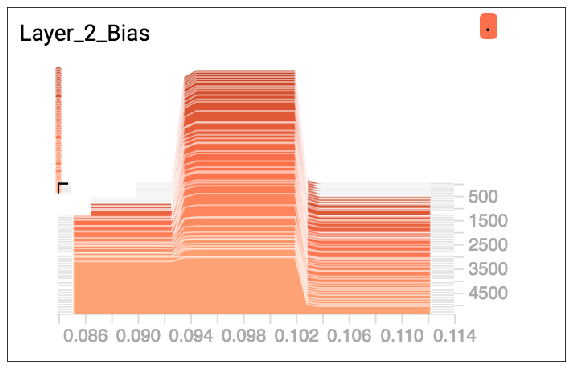

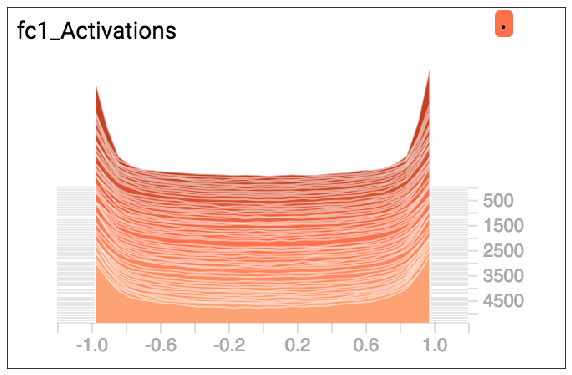

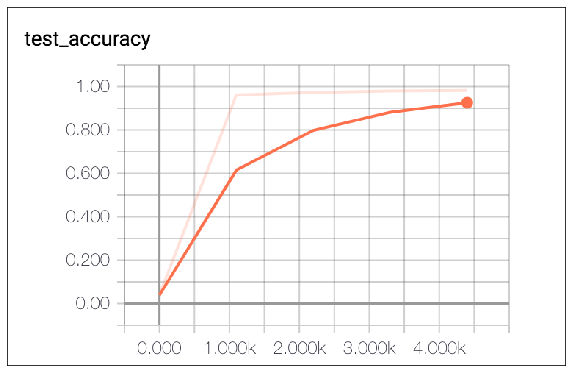

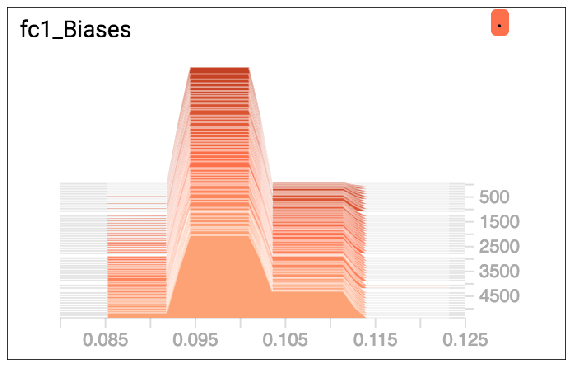

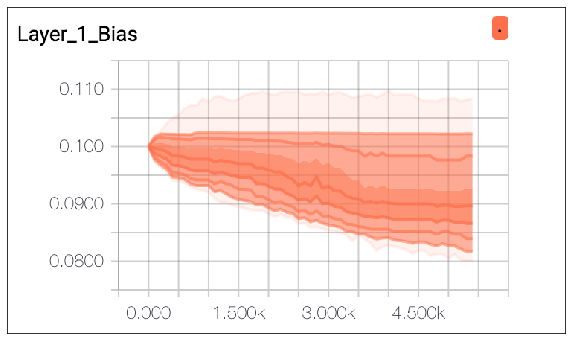

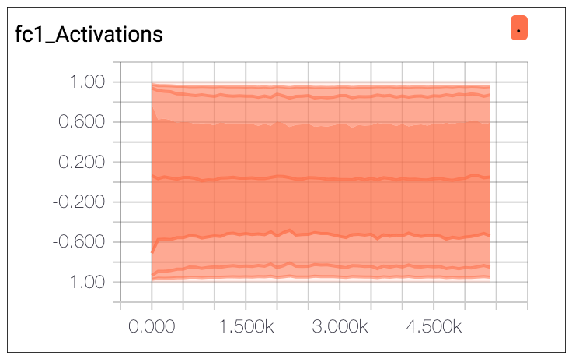

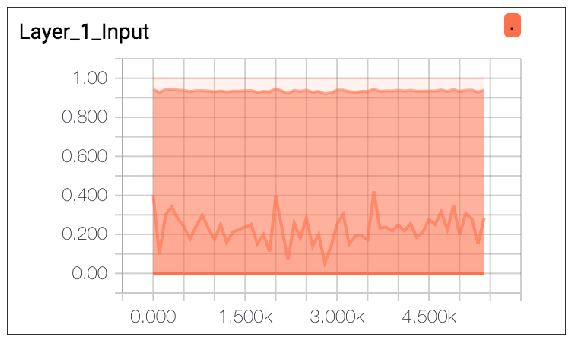

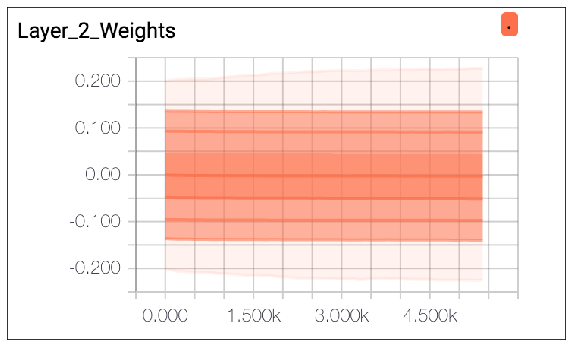

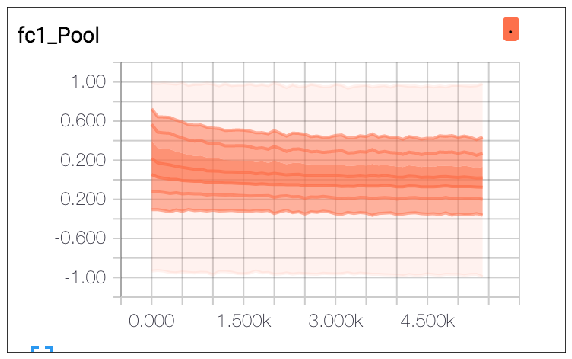

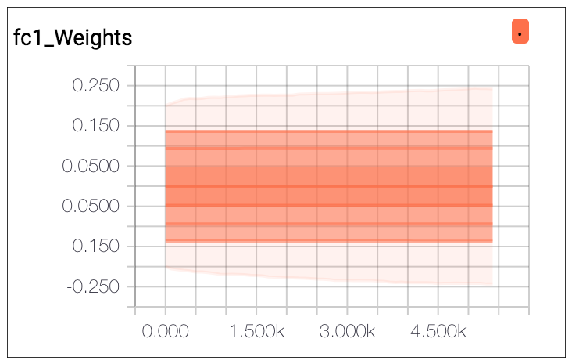

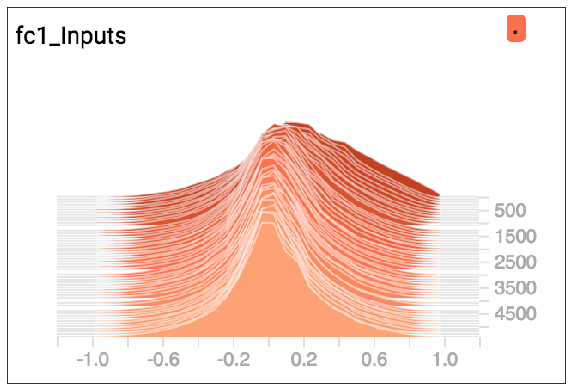

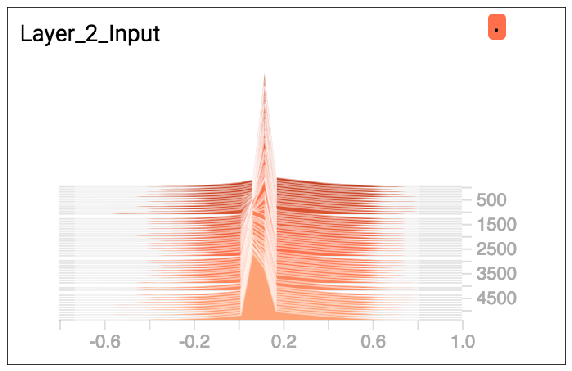

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
%pylab inline
arr = os.listdir("./images/run_2")
for file in arr:
    img=mpimg.imread("./images/run_2/"+file)
    figure(figsize = (10,10))
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()

## Alternate Run Number 2 with relu and xavier initialization

In [3]:
__author__ = 'tan_nguyen'

import os
import time

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Import Tensorflow and start a session
import tensorflow as tf
sess = tf.InteractiveSession()

def main():
    # Specify training parameters
    result_dir = './results/' 
    max_step = 5500 

    start_time = time.time() # start timing

    # placeholders for input data and input labeles
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None, 10])

    # reshape the input image
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # first convolutional layer
    W_conv1 = tf.get_variable("W_conv1", shape = [5, 5, 1, 32], \
                initializer=tf.contrib.layers.xavier_initializer())
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
    h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, \
                        strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], \
                        strides=[1, 2, 2, 1], padding='SAME')
    
    tf.summary.histogram("Layer_1_Input", x_image)
    tf.summary.histogram("Layer_1_Weights", W_conv1)
    tf.summary.histogram("Layer_1_Bias", b_conv1)
    tf.summary.histogram("Layer_1_Activations", h_conv1)
    tf.summary.histogram("Layer_1_Pooling", h_pool1)

    # second convolutional layer
    W_conv2 = tf.get_variable("W_conv2", shape=[5, 5, 32, 64], \
                initializer=tf.contrib.layers.xavier_initializer())
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, \
                        strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], \
                        strides=[1, 2, 2, 1], padding='SAME')
    
    tf.summary.histogram("Layer_2_Input", h_pool1)
    tf.summary.histogram("Layer_2_Weights", W_conv2)
    tf.summary.histogram("Layer_2_Bias", b_conv2)
    tf.summary.histogram("Layer_2_Activations", h_conv2)
    tf.summary.histogram("Layer_2_Pooling", h_pool2)

    # densely connected layer
    W_fc1 = tf.get_variable("W_fc1", shape = [3136, 1024], \
                    initializer=tf.contrib.layers.xavier_initializer()) 
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) 
    h_pool2_flat = tf.reshape(h_pool2, [-1, 3136])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
    tf.summary.histogram("fc1_Inputs", h_pool2)
    tf.summary.histogram("fc1_Weights", W_fc1)
    tf.summary.histogram("fc1_Biases", b_fc1)
    tf.summary.histogram("fc1_Activations", h_fc1)
    tf.summary.histogram("fc1_Pool", h_pool2_flat)

    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # softmax
    W_fc2 = tf.get_variable("W_fc2", shape = [1024, 10], \
                    initializer=tf.contrib.layers.xavier_initializer())  
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')
    
    tf.summary.histogram("h_fc1_drop", h_pool2)
    tf.summary.histogram("fc2_Weights", W_fc2)
    tf.summary.histogram("fc2_Biases", b_fc2)
    tf.summary.histogram("fc2_Activations", y_conv)

    # setup training
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * \
                                tf.log(y_conv), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,\
                                tf.float32), name='accuracy')

    # Add a scalar summary for the snapshot loss.
    tf.summary.scalar(cross_entropy.op.name, cross_entropy)
    
    # Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()
    
    validation_acc_summary = tf.summary.scalar('validation_accuracy', accuracy)
    test_acc_summary = tf.summary.scalar('test_accuracy', accuracy)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()

    # Instantiate a SummaryWriter to output summaries and the Graph.
    summary_writer = tf.summary.FileWriter(result_dir, sess.graph)

    # Run the Op to initialize the variables.
    sess.run(init)

    # run the training
    for i in range(max_step):
        batch = mnist.train.next_batch(50) 
        if i%100 == 0:
            # output the training accuracy every 100 iterations
            train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y_:batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))

            summary_str = sess.run(summary_op, feed_dict=\
                            {x: batch[0], y_: batch[1], keep_prob: 0.5})
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()

        # save the checkpoints every 1100 iterations
        if i % 1100 == 0 or i == max_step:
            checkpoint_file = os.path.join(result_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=i)
            test_accuracy = sess.run(test_acc_summary, feed_dict=\
                    {x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            validation_accuracy = sess.run(validation_acc_summary, feed_dict=\
                    {x: mnist.validation.images, \
                     y_: mnist.validation.labels, keep_prob: 1.0})
            summary_writer.add_summary(test_accuracy, i)
            summary_writer.add_summary(validation_accuracy, i)

        train_step.run(feed_dict={x: batch[0], \
                                  y_: batch[1], keep_prob: 0.5}) 
        
    # print/log test error
    print("test accuracy %g"%accuracy.eval(feed_dict=\
                    {x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

    stop_time = time.time()
    print('The training takes %f second to finish'%(stop_time - start_time))

if __name__ == "__main__":
    main()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.18
step 100, training accuracy 0.84
step 200, training accuracy 0.88
step 300, training accuracy 0.86
step 400, training accuracy 0.94
step 500, training accuracy 0.96
step 600, training accuracy 0.92
step 700, training accuracy 0.98
step 800, training accuracy 1
step 900, training accuracy 0.98
step 1000, training accuracy 0.98
step 1100, training accuracy 0.98
step 1200, training accuracy 0.96
step 1300, training accuracy 0.94
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 0.98
step 1900, training accuracy 0.98
step 2000, training accuracy 0.98
step 2100, training accuracy 0.98

Populating the interactive namespace from numpy and matplotlib


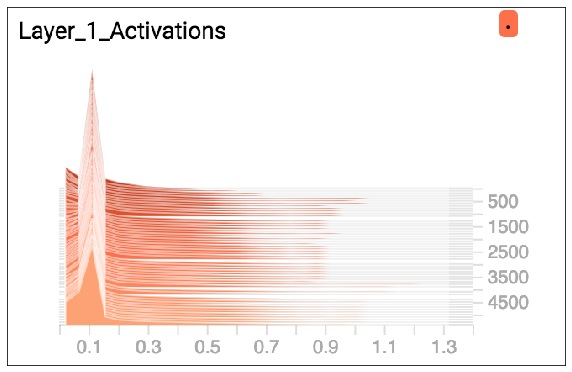

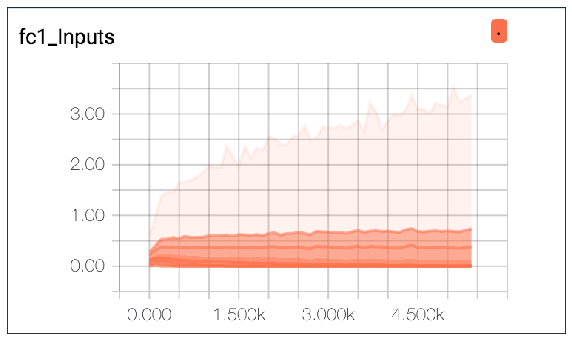

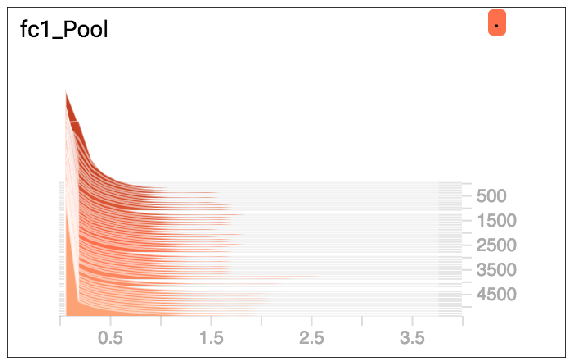

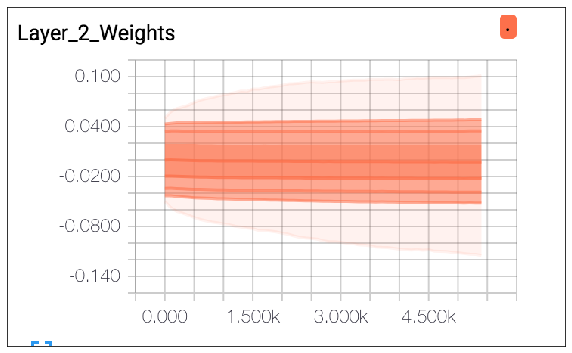

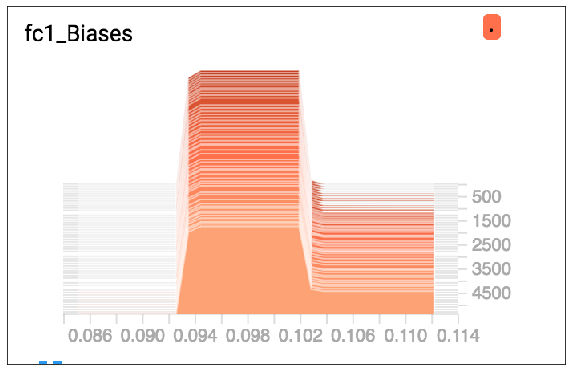

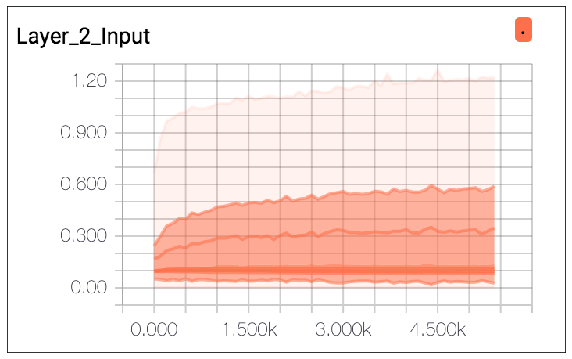

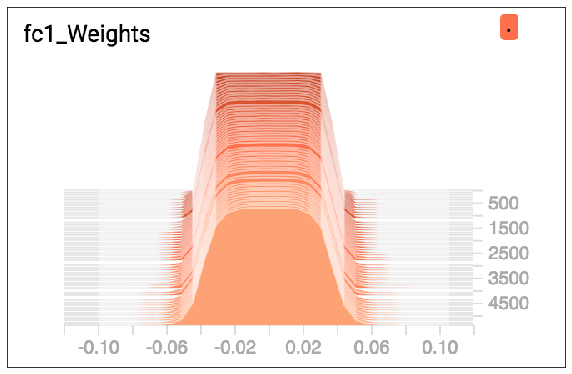

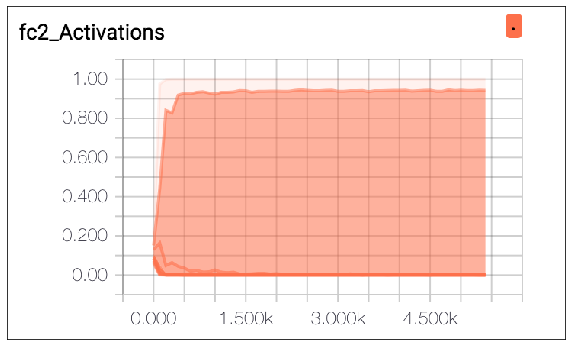

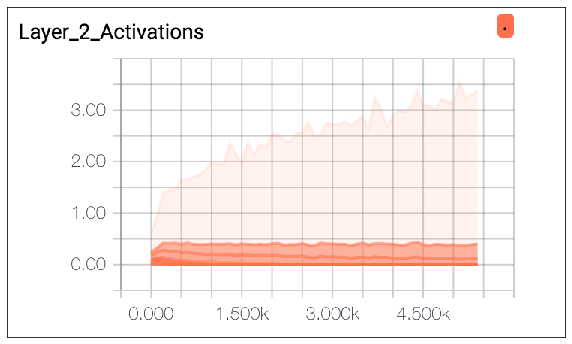

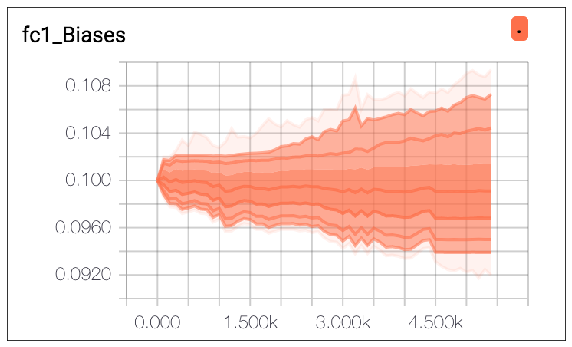

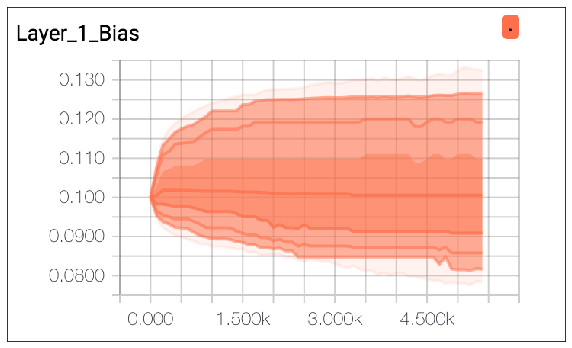

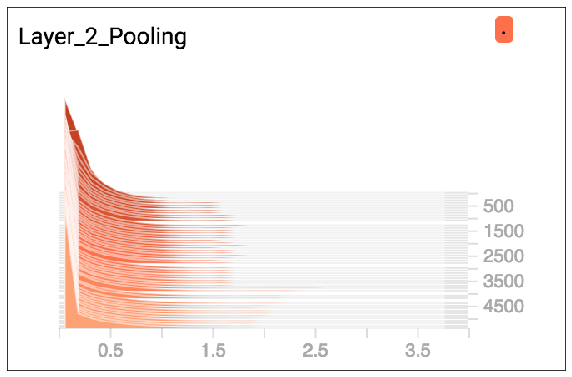

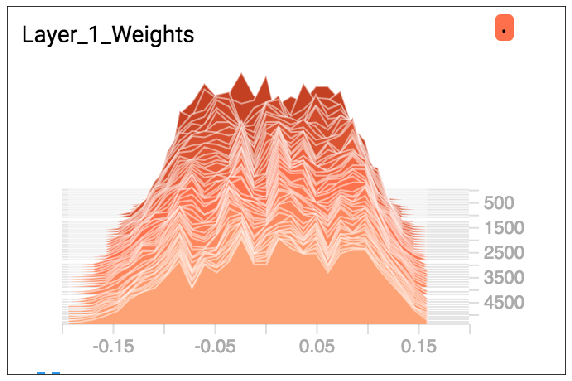

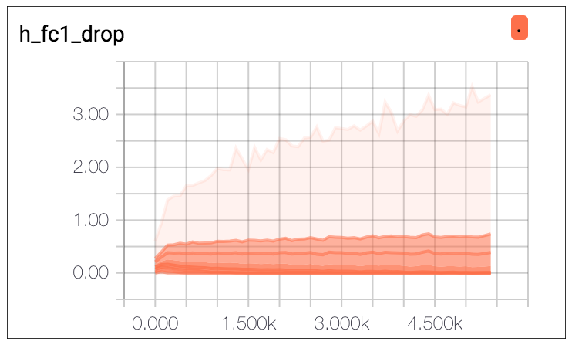

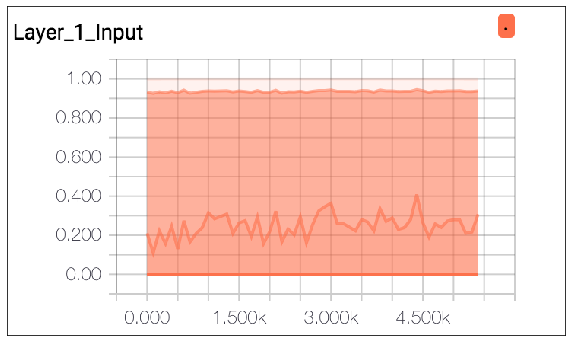

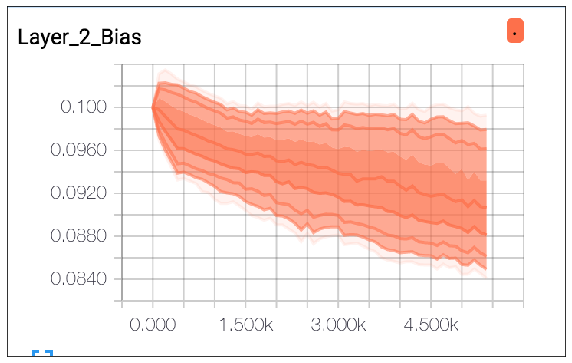

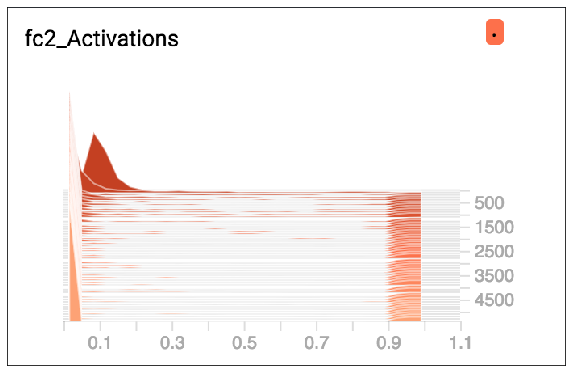

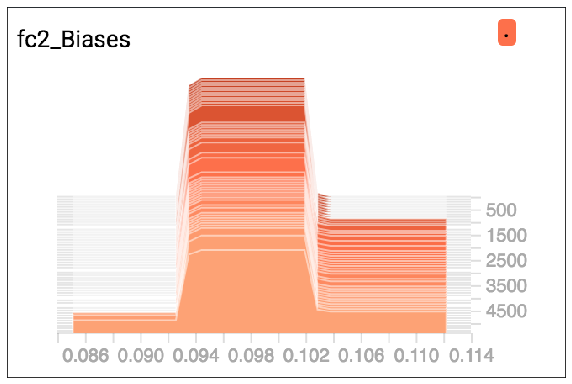

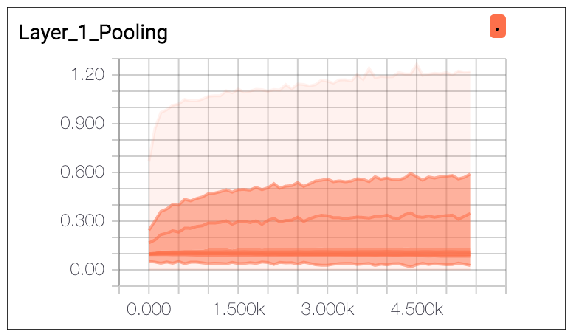

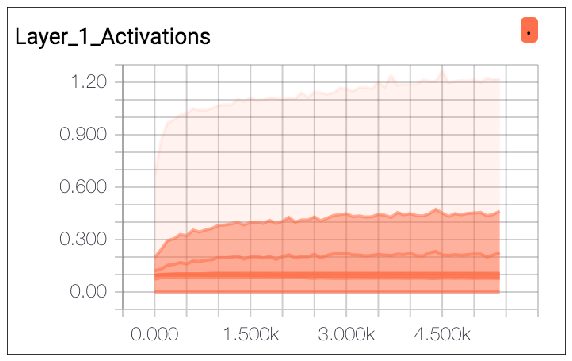

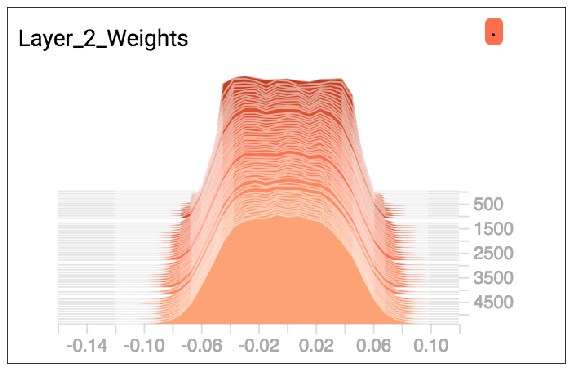

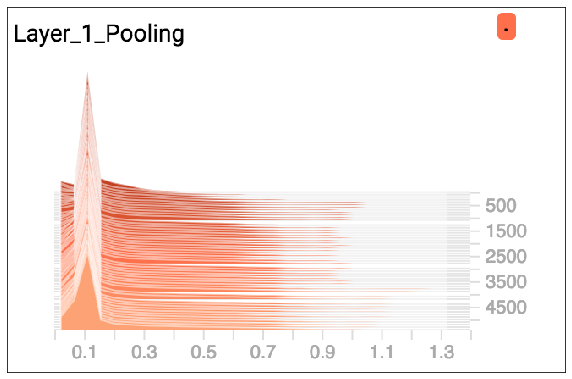

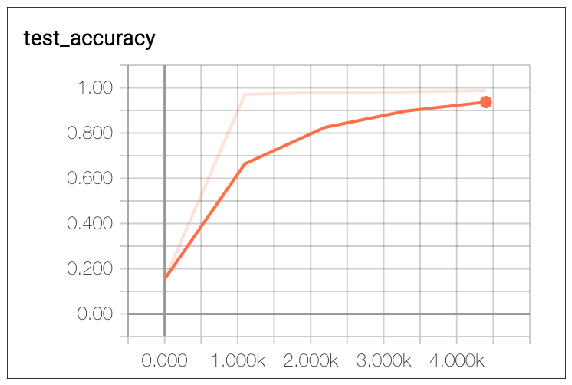

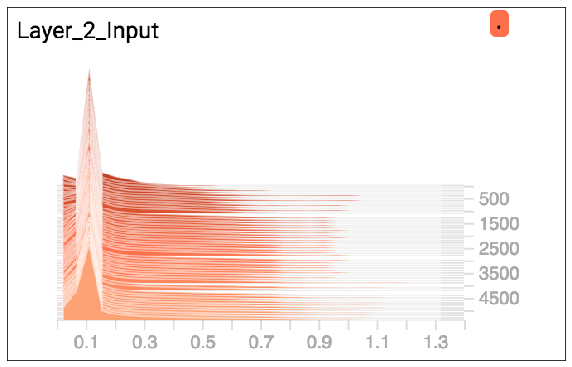

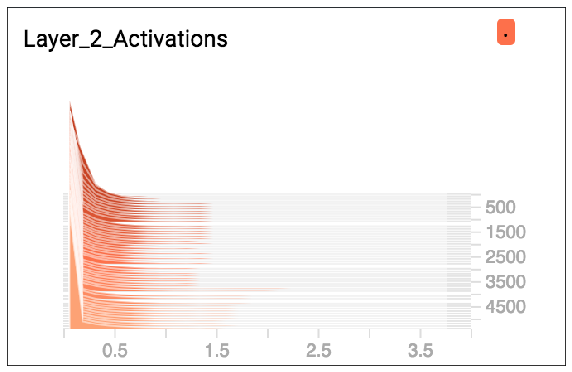

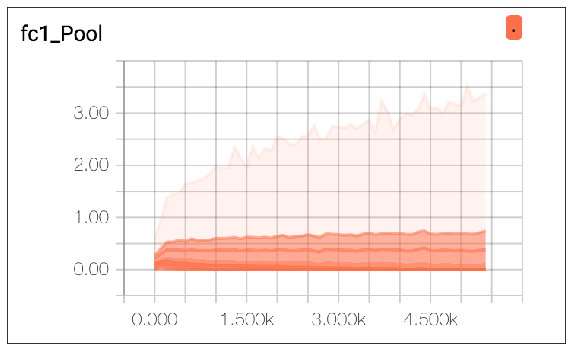

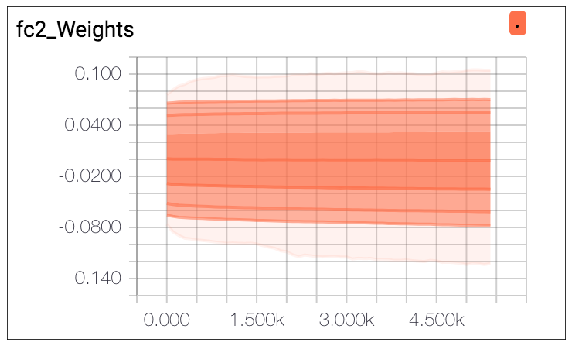

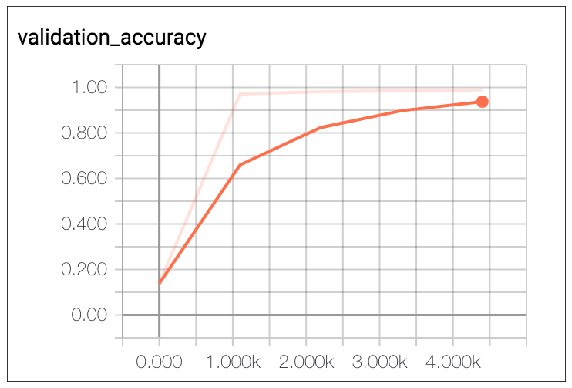

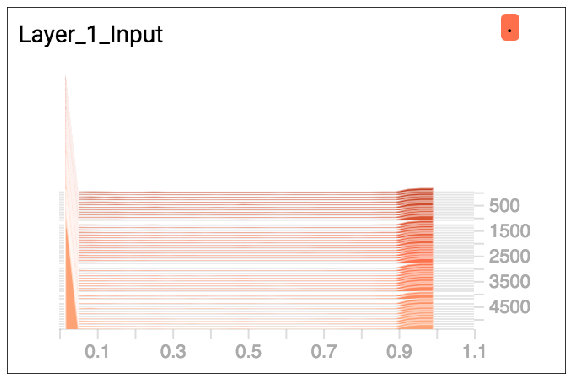

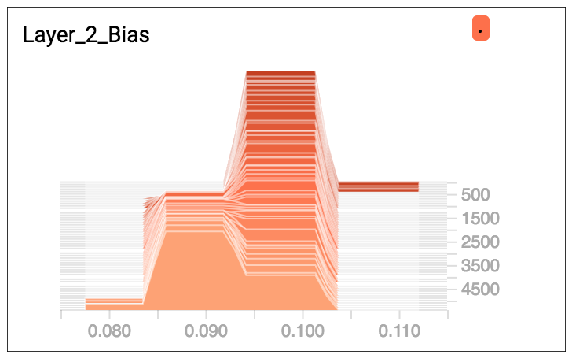

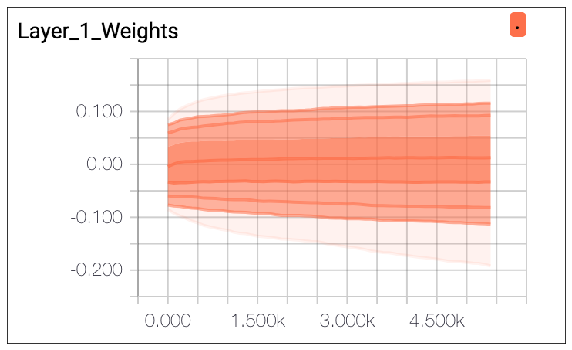

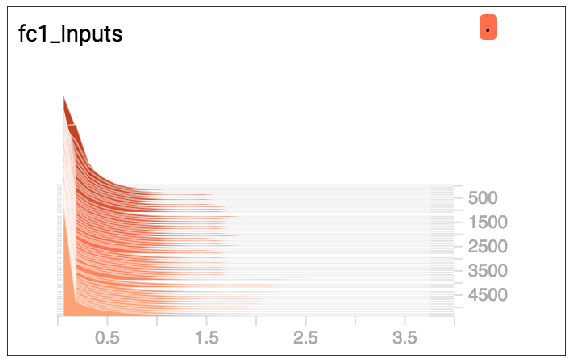

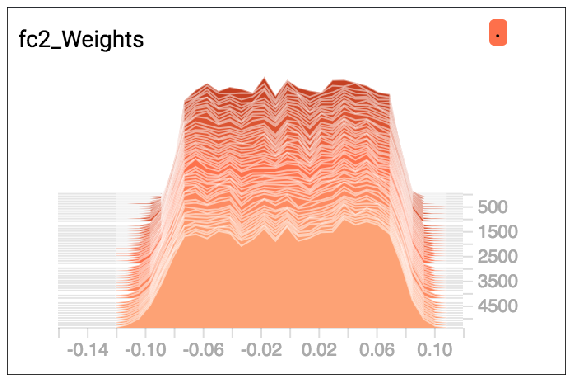

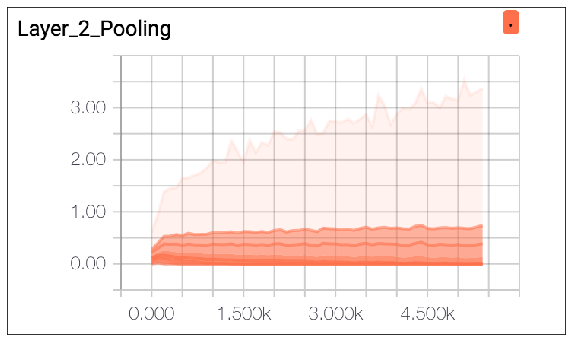

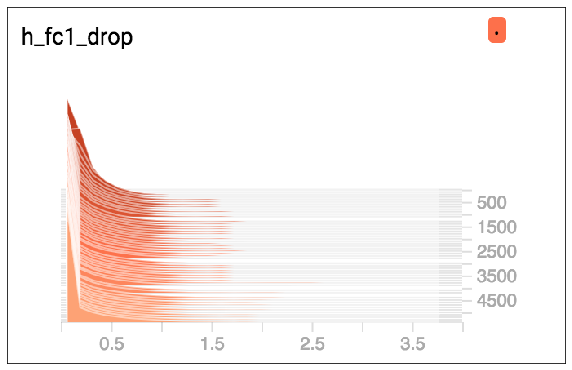

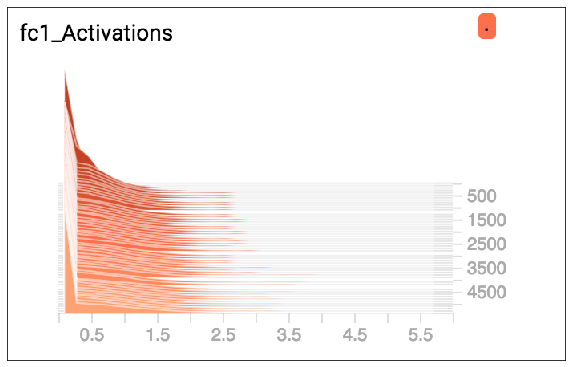

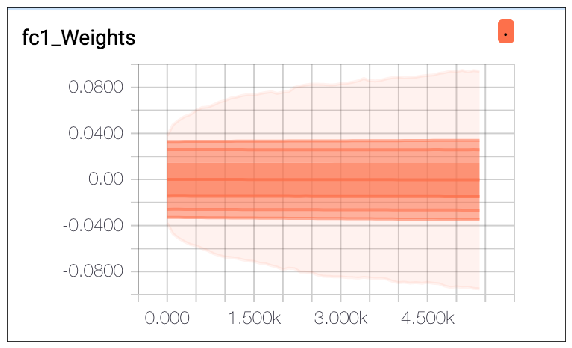

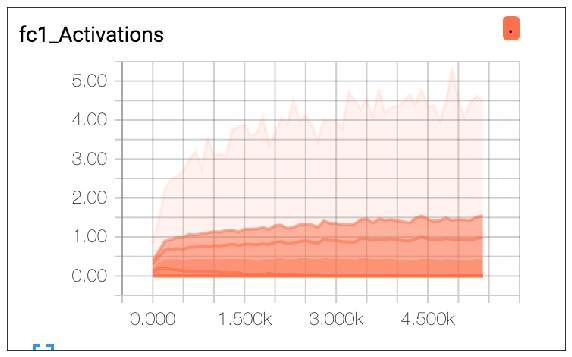

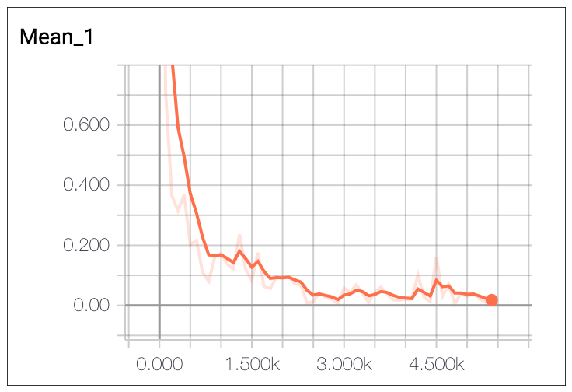

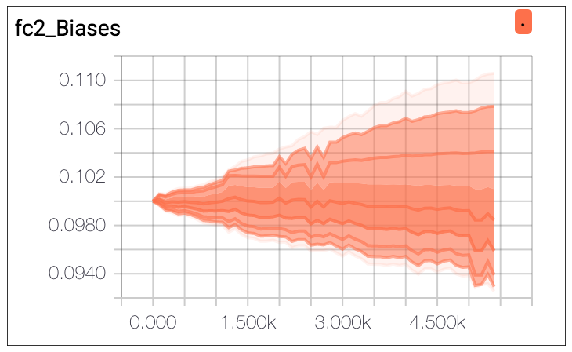

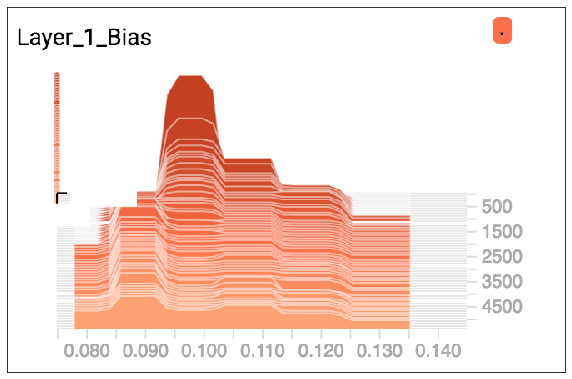

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
%pylab inline
arr = os.listdir("./images/run_3")
for file in arr:
    img=mpimg.imread("./images/run_3/"+file)
    figure(figsize = (10,10))
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()

## Describing the differences

There was no noticible difference in the loss or accuracy curves from any of these combinations. Between default relu and tanh, the distributions and histograms did not differ by much either. There was a major difference between the default relu/tanh histograms and the xavier initialization histograms. The difference comes from the fact that the weights start out with a different distribtion and as a result the final distribution looks different as well. H despite the difference in shape, there was no signficiant difference between the final accuracy.